In [1]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd


from datetime import datetime
from pathlib import Path
from sklearn.model_selection import train_test_split


import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import B_ID, whichBisSig, D0_decay_type, whichBisSig_NAHS

## set paths and conditions

In [35]:
save_data = True

delete_top_numFSP_evts=True

In [3]:
nfs_path = "/nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/moro/"

In [4]:
data_savedir = "data/fullBGseparation/"
rawData_subdir = "onlineRawData/fullBGseparation/"  
#rawData_subdir = "onlineRawData/test/"  

## load the raw data

In [5]:
fileFSPs = uproot.open(nfs_path + rawData_subdir + "FSPs.root:variables")

In [6]:
df_FSPs = fileFSPs.arrays(library="pd")
df_FSPs.shape[0]

54037144

In [7]:
evtInfo_File = uproot.open(nfs_path + rawData_subdir +  "evt_counter.root:variables")

In [8]:
evtInfo_df = evtInfo_File.arrays(library="pd")
evtInfo_df.shape[0]

2078001

## overview of data properties

### delete FSP duplicates 

In [9]:
FSPs_noDuplis = df_FSPs.drop_duplicates(subset=("uniqueParticleIdentifier","__event__"), keep='first')
#df_FSPs.groupby(["uniqueParticleIdentifier",'__event__', '__production__']).ngroups

print("FSPs per event:", round(FSPs_noDuplis.shape[0] / FSPs_noDuplis["__event__"].nunique(), 2))

FSPs per event: 17.47


<AxesSubplot:>

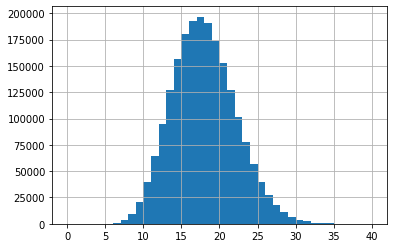

In [10]:
bins = np.linspace(0, 40, 41)

numberOfFSPs = pd.DataFrame({'numFSPs' : FSPs_noDuplis.groupby( ["__event__"] ).size()}).reset_index()
numberOfFSPs["numFSPs"].hist(bins=bins)

# pre selection and labeling

### which B is Bsig?

In [11]:
evtInfo_df['Bsig_uniqParID'] = evtInfo_df.apply(whichBisSig_NAHS, axis=1)

In [12]:
evtInfo_df['Bsig_uniqParID'].value_counts()

83886081.0    1088236
83886082.0     989765
Name: Bsig_uniqParID, dtype: int64

### label and filter D0 modes

In [13]:
evtInfo_df['D0_decay'] = evtInfo_df.apply(D0_decay_type, axis=1)

In [14]:
evtInfo_df['D0_decay'].value_counts()

notWanted     1733635
Kpipi0         183677
Kpipipi         67661
Kpipipipi0      48184
Kpi             44844
Name: D0_decay, dtype: int64

In [15]:
evtInfo_df = evtInfo_df[evtInfo_df['D0_decay'] != "notWanted"]
evtInfo_df.shape[0]

344366

In [16]:
print(FSPs_noDuplis.shape[0])
print(FSPs_noDuplis["__event__"].nunique())


FSPs_noDuplis = FSPs_noDuplis[FSPs_noDuplis['__event__'].isin(evtInfo_df["__event__"])]


print(FSPs_noDuplis.shape[0])
print(FSPs_noDuplis["__event__"].nunique())

36301643
2078001
5891752
344366


## label FSPs

In [17]:
FSPs_noDuplis['B_ID'] = FSPs_noDuplis.apply(B_ID, axis=1)

In [18]:
def labels(s):
    label = -1
    if int(s['B_ID']) == 0:
        label = 0 # background, cause not related to MC Particles
    else: 
        label = 1 # NOT background
    return label

In [19]:
FSPs_noDuplis['label'] = FSPs_noDuplis.apply(labels, axis=1)

In [20]:
FSPs_noDuplis['label'].value_counts()

1    5181009
0     710743
Name: label, dtype: int64

In [21]:
FSPs_noDuplis['label'].value_counts(normalize=True)

1    0.879366
0    0.120634
Name: label, dtype: float64

### check max num FSPs per event

<AxesSubplot:>

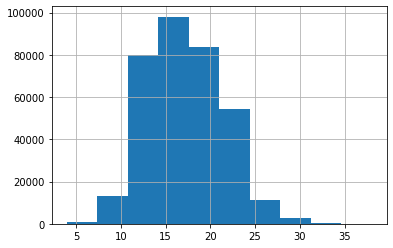

In [22]:
numberFSPsEvts = pd.DataFrame({'count' : FSPs_noDuplis.groupby(["__event__"]).size()}).reset_index()
numberFSPsEvts['count'].hist()

In [23]:
numberFSPsEvts['count'].max()

38

## delete delete_top_numFSP_evts

In [24]:
# print first to adjust percentile used
print("original max FSPs:",numberFSPsEvts["count"].max())
for percentile_lvl in [0.995,0.996,0.997,0.998,0.999]:
    print(percentile_lvl)
    percentile = numberFSPsEvts["count"].quantile(q=percentile_lvl)
    cut_numberFSPsEvts = numberFSPsEvts[numberFSPsEvts["count"] < percentile]
    
    #TMP_df_FSPs = df_FSPs[df_FSPs['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    TMP_FSPs_noDuplis = FSPs_noDuplis[FSPs_noDuplis['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    
    print("would delete", round(100 - (TMP_FSPs_noDuplis.shape[0]/TMP_FSPs_noDuplis.shape[0])*100,6),"% of evts")
    print("new max FSPs:",cut_numberFSPsEvts["count"].max())

original max FSPs: 38
0.995
would delete 0.0 % of evts
new max FSPs: 28
0.996
would delete 0.0 % of evts
new max FSPs: 28
0.997
would delete 0.0 % of evts
new max FSPs: 28
0.998
would delete 0.0 % of evts
new max FSPs: 29
0.999
would delete 0.0 % of evts
new max FSPs: 30


In [25]:
print(FSPs_noDuplis.shape[0])
print(evtInfo_df.shape[0])
numEvtsBeforeCut = FSPs_noDuplis.shape[0]

if delete_top_numFSP_evts:
    delete_percentileLvl = 0.995
    print("used delete_percentileLvl:",delete_percentileLvl)
    
    
    print(numberFSPsEvts["count"].describe())
    
    percentile = numberFSPsEvts["count"].quantile(q=delete_percentileLvl)
    cut_numberFSPsEvts = numberFSPsEvts[numberFSPsEvts["count"] < percentile]
    
    FSPs_noDuplis = FSPs_noDuplis[FSPs_noDuplis['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    evtInfo_df = evtInfo_df[evtInfo_df['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    
print(FSPs_noDuplis.shape[0])
print(evtInfo_df.shape[0])
print("deleted", round(100 - (FSPs_noDuplis.shape[0]/numEvtsBeforeCut)*100,4),"% of events")
numberFSPsEvts = pd.DataFrame({'count' : FSPs_noDuplis.groupby(["__event__"]).size()}).reset_index()
print(numberFSPsEvts["count"].describe())

5891752
344366
used delete_percentileLvl: 0.995
count    344366.000000
mean         17.108983
std           4.054297
min           4.000000
25%          14.000000
50%          17.000000
75%          20.000000
max          38.000000
Name: count, dtype: float64
5839015
342612
deleted 0.8951 % of events
count    342612.000000
mean         17.042646
std           3.955705
min           4.000000
25%          14.000000
50%          17.000000
75%          20.000000
max          28.000000
Name: count, dtype: float64


### impute the nan values of variables

In [26]:
## data preprocessing, dealing with NaN
imputelist = [["pionID",-1.],["kaonID",-1.],["electronID",-1.],["muonID",-1.],["protonID",-1.]
              ,["clusterReg",-1.],["clusterE9E21",-1.]
              ]
for impute in imputelist:
    column_name = impute[0]
    impute_val = impute[1]
    print(FSPs_noDuplis[FSPs_noDuplis[column_name].isna() == True].shape[0])    
    mask = FSPs_noDuplis[column_name].isna() == 1
    FSPs_noDuplis.loc[mask, column_name] = impute_val
    print(FSPs_noDuplis[FSPs_noDuplis[column_name].isna() == True].shape[0])

2783637
0
2783637
0
2783637
0
2783637
0
2783637
0
1112223
0
1112223
0


### check that each particles occurs only ones; count must be == 1 for all

In [64]:
groupsFSPs_uniqParID = pd.DataFrame({'count' : FSPs_noDuplis.groupby( ["__event__","uniqueParticleIdentifier"] ).size()}).reset_index()
groupsFSPs_uniqParID.value_counts('count')

count
1    20390
dtype: int64

## save & load labeled and processed df's

### save

In [27]:
FSPs_noDuplis.to_csv(nfs_path + rawData_subdir +  "FSPs_noDuplis_preProcessed.csv")
evtInfo_df.to_csv(nfs_path + "evtInfo_df_preProcessed.csv")

In [28]:
print("save successful")

save successful


### load

In [6]:
FSPs_noDuplis = pd.read_csv(nfs_path + rawData_subdir +  "FSPs_noDuplis_preProcessed.csv")

In [ ]:
evtInfo_df = pd.read_csv(nfs_path + rawData_subdir +  "evtInfo_df_preProcessed.csv")

In [11]:
numberOfFSPs[(numberOfFSPs["numFSPs"] >= 5)  & (numberOfFSPs["numFSPs"] <= 13)].shape[0]

49239

<AxesSubplot:>

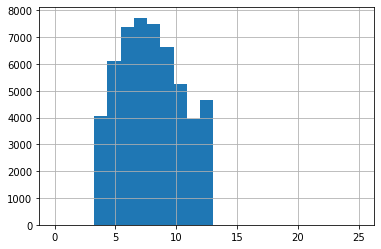

In [15]:
bins = np.linspace(0, 25, 24)

numberOfFSPs = pd.DataFrame({'numFSPs' : nonBsig_FSPs.groupby( ["__event__"] ).size()}).reset_index()
numberOfFSPs[(numberOfFSPs["numFSPs"] >= 4)  & (numberOfFSPs["numFSPs"] <= 13)]["numFSPs"].hist(bins=bins)

In [14]:
numberOfFSPs[(numberOfFSPs["numFSPs"] >= 4)  & (numberOfFSPs["numFSPs"] <= 13)].shape[0]

53314

<AxesSubplot:>

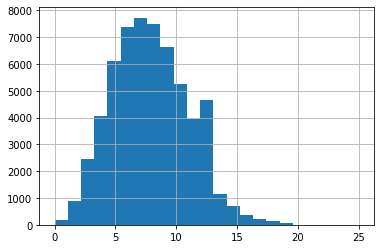

In [12]:
numberOfFSPs["numFSPs"].hist(bins=bins)

# beginning of data prod

In [29]:
df_FSPs_final = FSPs_noDuplis

## definition of input vars to be saved

In [39]:
variable_combinations = [
    [[],"moro_only4mom"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"moro_allExtras"],
    [["charge","dr","clusterE9E21"],"moro_chrg_dr_E9E21"],
    [[    "charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"moro_no_M"],
    [["M",         "dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"moro_no_charge"],
    [["M","charge",     "dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"moro_no_dr"],
    [["M","charge","dr",     "clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"moro_no_dz"],
    [["M","charge","dr","dz",             "clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"moro_no_clReg"],
    [["M","charge","dr","dz","clusterReg",               "pionID","kaonID","electronID","muonID","protonID",
     ],"moro_no_E9E21"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21",         "kaonID","electronID","muonID","protonID",
     ],"moro_no_pID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID",         "electronID","muonID","protonID",
     ],"moro_no_kID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID",             "muonID","protonID",
     ],"moro_no_eID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID"         ,"protonID",
     ],"moro_no_muID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID"           ,
     ],"moro_no_proID"],
    [["charge","pionID","muonID",],"moro_charge_mpIDs"],
    [["charge"],"moro_charge"]
]

In [40]:
len(variable_combinations)

16

## start of saving

In [41]:
numFSPs = pd.DataFrame({'count' : df_FSPs_final.groupby( ["__event__"] ).size()}).reset_index()

minFSPs = numFSPs["count"].min()
maxFSPs = numFSPs["count"].max()
print("minFSPs:",minFSPs)
print("maxFSPs:",maxFSPs,'\n')
print("num Events:",numFSPs.shape[0],'\n')

print("save_data:",save_data)

df_FSPs_final['numFSPs'] = df_FSPs_final.groupby('__event__')['__event__'].transform('count')

minFSPs: 4
maxFSPs: 28 

num Events: 342612 

save_data: True


In [42]:
now = datetime.now()
print("time at start =", now)

time at start = 2022-02-01 12:50:44.131318


In [ ]:
#minFSPs = 4 
for var_comb in variable_combinations:
    ablationSub = var_comb[1]
    data_dir = Path(nfs_path + data_savedir + "/" + ablationSub + "/")    
    if save_data:
        data_dir.mkdir(parents=True, exist_ok=True)
    print("Will save data to:", data_dir,'is', save_data ,'\n')


    
    for num_FSPs_toData in range(minFSPs, maxFSPs+1):
        df_num_subset = df_FSPs_final.copy()
        df_num_subset = df_num_subset[df_num_subset['numFSPs'] == num_FSPs_toData]


        numEvents = df_num_subset.__event__.nunique()
        print("numEvents:",numEvents)
        print("num_FSPs_toData:",num_FSPs_toData)  
        if numEvents == 0:
            print("skipped because empty \n")
            continue

        if numEvents < 10:
            print("skipped because <10 events \n")
            continue

        num_features = 4 + len(var_comb[0])
        leaves = np.zeros((numEvents, num_FSPs_toData,  num_features))  
        SA_target =  np.zeros((numEvents, num_FSPs_toData))
        global_tag = np.chararray((numEvents, num_FSPs_toData + 1), itemsize=30)

        event_list = df_num_subset[df_num_subset["numFSPs"] == num_FSPs_toData]["__event__"].unique()
        #print("len(event_list):",len(event_list))
        for i in range(numEvents):

            event_iter = event_list[i]

            global_tag_masterInfo = "evt" + str(event_iter)
            global_tag[i,-1] = global_tag_masterInfo
            #print("global_tag[i,-1]:",global_tag[i,-1])
            #print("i:",i,"event_iter:",event_iter)

            event_df = df_num_subset[df_num_subset.__event__ == event_iter]

            for j in range(num_FSPs_toData):
                #print("numParticle:",j)
                particle = event_df.iloc[j]

                #print(particle["mcPDG"],particle["px"],particle["py"],particle["pz"],particle["E"])
                leaves[i,j,0] = particle["px"]
                leaves[i,j,1] = particle["py"]
                leaves[i,j,2] = particle["pz"]
                leaves[i,j,3] = particle["E"]
                
                for k in range(len(var_comb[0])):
                    leav_idx = k + 4
                    leaves[i,j,leav_idx] = particle[var_comb[0][k]]
                    



                global_tag_Info = str((particle["mcPDG"])) 
                global_tag[i,j] = global_tag_Info

        
                SA_target[i,j] = particle["label"]

            del event_df


        # shuffle the data    
        for idx in np.arange(leaves.shape[0]):   # arange is like range but gives ndarray instead of list
            perms = np.random.permutation(leaves.shape[1])

            leaves[idx,:] = leaves[idx,perms]
            SA_target[idx,:] = SA_target[idx,perms]
            global_tag[idx,0:-1] = global_tag[idx,perms]





        #print(global_tag)
        train_ratio = 0.8
        validation_ratio = 0.2
        #test_ratio = 0.1

        print("leaves.shape:",leaves.shape)
        print("SA_target.shape:",SA_target.shape)
        print("global_tag.shape:",global_tag.shape)


        print("leaves[0]:",leaves[0])
        print("SA_target[0]:",SA_target[0])
        print("global_tag[0]:",global_tag[0])

        x=leaves
        y=SA_target
        z=global_tag

        x_train, x_val, y_train, y_val, z_train, z_val = train_test_split(x, y, z, test_size=1 - train_ratio, shuffle=False)
        #x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=1 - train_ratio, shuffle=False)
        #x_val, x_test, y_val, y_test, z_val, z_test = train_test_split(x_test, y_test, z_test, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=False) 

        if save_data==True:
            np.save(data_dir / "leaves_train_FSP{}.npy".format(num_FSPs_toData), x_train)
            np.save(data_dir / "is_left_arr_train_FSP{}.npy".format(num_FSPs_toData), y_train)
            np.save(data_dir / "global_tag_train_FSP{}.npy".format(num_FSPs_toData), z_train)

            np.save(data_dir / "leaves_val_FSP{}.npy".format(num_FSPs_toData), x_val)
            np.save(data_dir / "is_left_arr_val_FSP{}.npy".format(num_FSPs_toData), y_val)
            np.save(data_dir / "global_tag_val_FSP{}.npy".format(num_FSPs_toData), z_val)

            #np.save(data_dir / "leaves_test_FSP{}.npy".format(num_FSPs_toData), x_test)
            #np.save(data_dir / "is_left_arr_test_FSP{}.npy".format(num_FSPs_toData), y_test)
            #np.save(data_dir / "global_tag_test_FSP{}.npy".format(num_FSPs_toData), z_test)


        print("")


        del df_num_subset


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/moro/data/fullBGseparation/moro_only4mom is True 

numEvents: 4
num_FSPs_toData: 4
skipped because <10 events 

numEvents: 27
num_FSPs_toData: 5
leaves.shape: (27, 5, 4)
SA_target.shape: (27, 5)
global_tag.shape: (27, 6)
leaves[0]: [[ 0.00736095 -0.29261038 -0.14873509  0.59288626]
 [ 1.09662092  1.51732123  0.87938327  2.12646962]
 [-0.47253197 -1.09228849  0.72353309  1.47770015]
 [ 0.65696508 -0.56385249  0.354702    1.05785784]
 [-1.31062663  0.82691729  0.48242924  1.69646376]]
SA_target[0]: [1. 1. 1. 1. 1.]
global_tag[0]: [b'-211.0' b'-13.0' b'321.0' b'-11.0' b'-321.0' b'evt3673555']

numEvents: 182
num_FSPs_toData: 6
leaves.shape: (182, 6, 4)
SA_target.shape: (182, 6)
global_tag.shape: (182, 7)
leaves[0]: [[ 0.6011706  -0.04596588  0.69852716  1.04650662]
 [ 0.06162059  0.05315937  0.08903605  0.50820016]
 [ 0.17139569  0.27453274 -0.05184897  0.5925791 ]
 [ 0.23920354  0.00936492  0.57593763  0.79544149]
 [


numEvents: 33451
num_FSPs_toData: 16
leaves.shape: (33451, 16, 4)
SA_target.shape: (33451, 16)
global_tag.shape: (33451, 17)
leaves[0]: [[-3.78950685e-01 -2.10459039e-01  5.66637218e-01  8.67577856e-01]
 [ 1.28184780e-02 -6.36323988e-02  4.44704629e-02  7.86830200e-02]
 [-2.32570842e-02 -2.06365995e-02  5.54825999e-02  6.36009441e-02]
 [-7.48464614e-02  1.52275413e-02  9.41361561e-02  1.21224943e-01]
 [-8.20541799e-01 -5.44871271e-01  1.84264910e+00  2.14691552e+00]
 [-9.70057100e-02  1.42493904e-01 -7.67756836e-04  2.21799689e-01]
 [-1.33959129e-01  8.74252338e-03  9.50215384e-03  5.11692038e-01]
 [-8.85372877e-01  5.11225760e-01  1.04650147e-01  1.14013400e+00]
 [-1.83310881e-01  1.63771972e-01 -7.07414374e-02  5.56008507e-01]
 [-1.73843741e-01 -5.00656143e-02 -1.22159958e-01  5.39785363e-01]
 [ 6.49030581e-02  7.46223927e-02  2.98435204e-02  5.04369423e-01]
 [ 1.98220015e-01 -3.22186351e-02 -1.32470012e-01  2.40577469e-01]
 [ 1.62889266e+00 -3.63508761e-01  1.39350557e+00  2.229575


numEvents: 15151
num_FSPs_toData: 22
leaves.shape: (15151, 22, 4)
SA_target.shape: (15151, 22)
global_tag.shape: (15151, 23)
leaves[0]: [[-0.05131124  0.10291394  0.11367629  0.16169855]
 [ 0.41199499  0.25435948  0.01770572  0.6917146 ]
 [ 0.02093733 -0.03118338 -0.01984378  0.04248   ]
 [ 0.13526736 -0.0761694   0.26217163  0.30468508]
 [ 0.65954161 -0.12143655 -0.05207329  0.83436836]
 [ 0.23681033  1.26722109  1.31344616  1.90546221]
 [-0.19962554 -0.17121136 -0.06239599  0.27029048]
 [-0.79408699  0.12671088  0.23622394  0.97270166]
 [ 0.03821665  0.0238119   0.09004294  0.10067398]
 [-0.14911096  0.07289163 -0.01004501  0.16627739]
 [-0.1840919  -0.13645567  0.07037186  0.23971269]
 [ 0.05286684 -0.02837103  0.07158206  0.09340134]
 [ 0.2427175  -0.49464244  0.51158923  0.8994573 ]
 [ 0.3353343   0.15063861  0.30472925  0.68681728]
 [ 0.78509057  0.00191824  0.5301832   1.06826124]
 [ 0.13765426 -0.1257861   0.22268294  0.57277875]
 [-0.05100363  0.05102056  0.00998623  0.072829


numEvents: 2281
num_FSPs_toData: 27
leaves.shape: (2281, 27, 4)
SA_target.shape: (2281, 27)
global_tag.shape: (2281, 28)
leaves[0]: [[ 1.79802403e-01 -1.50139993e-02  8.48528221e-02  1.99384868e-01]
 [-1.32577509e-01 -2.47035665e-03  5.69987409e-02  1.44332099e-01]
 [ 2.42614560e-02 -3.53818908e-02 -4.19407804e-03  4.31055302e-02]
 [ 1.21779561e-01 -1.97859749e-01  2.34991107e-02  5.46120793e-01]
 [ 1.78721040e-01  4.38922755e-02 -5.33192046e-02  1.91600312e-01]
 [ 1.28464191e-03 -4.32119071e-02 -3.75218131e-02  5.72433898e-02]
 [ 8.08970071e-03  6.96049854e-02  3.04519180e-02  7.64042968e-02]
 [-6.19036108e-02 -4.95935567e-02  1.07742287e-01  1.93338746e-01]
 [-8.18058178e-02 -1.38308570e-01 -1.50897056e-02  5.19390145e-01]
 [-1.79721594e-01 -3.52906227e-01 -3.34533514e-04  6.32897890e-01]
 [ 3.55723165e-02 -8.50721002e-02  4.04742695e-02  1.00701631e-01]
 [-1.35212076e+00  6.71396777e-02  9.69605088e-01  1.73683312e+00]
 [-8.62852633e-02  1.11483205e-02  8.65669921e-02  1.22732538e-

leaves.shape: (614, 7, 15)
SA_target.shape: (614, 7)
global_tag.shape: (614, 8)
leaves[0]: [[ 7.94763446e-01  6.03735328e-01  3.28268826e-01  1.16087151e+00
   4.93676990e-01  1.00000000e+00  1.74182790e-03  2.35154871e-02
   2.00000000e+00  9.89257812e-01  1.00000000e+00  2.02190681e-14
   2.37696238e-12  9.53772388e-11  3.29556496e-22]
 [-1.22991419e+00  1.60061407e+00 -2.18222558e-01  2.08949572e+00
   4.93676990e-01  1.00000000e+00  1.23183053e-03  3.20580752e-03
   2.00000000e+00  9.58984375e-01  5.93752854e-13  1.00000000e+00
   1.05073305e-15  9.29529123e-14  1.39559006e-29]
 [-1.95501313e-01 -1.49536356e-01  4.73898888e-01  7.27240683e-01
   4.93676990e-01 -1.00000000e+00  1.72044603e-02  1.79962106e-02
   1.00000000e+00  9.28710938e-01  9.75887865e-01  2.70526211e-06
   5.97818767e-07  2.41088324e-02  3.84333573e-23]
 [ 1.28874602e-02 -3.49479347e-01  2.87701696e-01  6.69918754e-01
   4.93676990e-01 -1.00000000e+00  2.77900506e-03  9.66603876e-03
   2.00000000e+00  1.00000000e


numEvents: 12016
num_FSPs_toData: 11
leaves.shape: (12016, 11, 15)
SA_target.shape: (12016, 11)
global_tag.shape: (12016, 12)
leaves[0]: [[-3.70426059e-001  1.18004128e-001  2.31404579e-003  6.28381067e-001
   4.93676990e-001  1.00000000e+000  3.57580714e-003  8.18123270e-003
   2.00000000e+000  6.25976562e-001  1.00000000e+000  5.17636842e-083
   3.03049505e-016  1.06693640e-010  1.20215293e-102]
 [ 1.63586959e-002 -3.44993770e-002  1.12972721e-001  1.83577074e-001
   1.39570385e-001 -1.00000000e+000  1.09849433e-001 -2.01272122e-001
  -1.00000000e+000 -1.00000000e+000  4.25949681e-001  6.73184702e-003
   6.73184724e-002  4.25949681e-001  6.73184702e-003]
 [ 2.08432972e-001 -2.89411366e-001  9.71446484e-002  6.16731138e-001
   4.93676990e-001 -1.00000000e+000  1.60348006e-002 -6.62159611e-003
   2.00000000e+000  9.79492188e-001  2.41557286e-016  7.47186650e-052
   9.70114416e-003  9.90298856e-001  5.46323494e-054]
 [ 4.27306481e-002  2.14652121e-001  2.84522474e-001  6.10386312e-001



numEvents: 28031
num_FSPs_toData: 14
leaves.shape: (28031, 14, 15)
SA_target.shape: (28031, 14)
global_tag.shape: (28031, 15)
leaves[0]: [[ 5.47433317e-001 -1.42433786e+000  1.75257642e-002  1.60388457e+000
   4.93676990e-001  1.00000000e+000  6.23214939e-004  5.08410549e-003
   2.00000000e+000  9.62890625e-001  3.50368675e-006  2.09526071e-022
   9.99996496e-001  2.31316035e-017  4.59912697e-025]
 [-6.99774325e-001  3.96216154e-001  1.26684057e-002  8.04258562e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.66796875e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000 -1.00000000e+000]
 [ 3.51926275e-002  4.01321473e-003  2.05144212e-002  4.09324858e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000 -1.00000000e+000]
 [ 4.37897146e-001 -5.85900664e-001 -1.13117838e+000  1.35428133e+000



numEvents: 33208
num_FSPs_toData: 17
leaves.shape: (33208, 17, 15)
SA_target.shape: (33208, 17)
global_tag.shape: (33208, 18)
leaves[0]: [[-2.49987599e-002  4.47184779e-003  4.62633781e-002  5.27753311e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   1.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000 -1.00000000e+000]
 [-4.01294976e-001  8.45981017e-002  4.31196240e-004  6.41803438e-001
   4.93676990e-001 -1.00000000e+000  1.23894282e-002  4.75510971e-003
   2.00000000e+000  8.08593750e-001  9.99941183e-001  4.46029664e-029
   2.69146740e-010  5.88165870e-005  3.70488275e-047]
 [-1.76685601e-002 -1.19177373e-002  5.74289337e-002  6.12559622e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   1.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000 -1.00000000e+000]
 [ 7.79484153e-001  5.79370677e-001  2.01713338e-001  1.10800323e+000



numEvents: 28289
num_FSPs_toData: 19
leaves.shape: (28289, 19, 15)
SA_target.shape: (28289, 19)
global_tag.shape: (28289, 20)
leaves[0]: [[-2.24522382e-01  1.27552703e-01  5.06037138e-02  2.63136330e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.90234375e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 5.61974406e-01 -7.70373881e-01  6.62083507e-01  1.26149225e+00
   4.93676990e-01 -1.00000000e+00  3.05963879e-03  1.86422854e-02
  -1.00000000e+00 -1.00000000e+00  2.38136639e-02  7.38113362e-01
   1.27793246e-06  6.46041193e-05  2.38006891e-01]
 [ 1.63979337e-01  3.60911459e-01  3.02799530e-02  6.33861302e-01
   4.93676990e-01  1.00000000e+00  3.54787135e-01  5.33288085e-01
   2.00000000e+00  1.00000000e+00  8.19586094e-01  2.58360948e-08
   3.59171448e-02  1.44496735e-01  6.05876596e-25]
 [ 2.47591838e-01 -5.62365353e-01 -7.72338808e-02  7.91983934e-01
   4.93676990e-01  1.00000000e+00  2.61288168e-03


numEvents: 19863
num_FSPs_toData: 21
leaves.shape: (19863, 21, 15)
SA_target.shape: (19863, 21)
global_tag.shape: (19863, 22)
leaves[0]: [[-5.80863282e-02 -2.06547394e-01  3.30653518e-01  6.31731405e-01
   4.93676990e-01  1.00000000e+00  1.01364368e-02 -1.85901993e-02
   1.00000000e+00  8.70117188e-01  8.74774971e-01  1.92042207e-14
   6.95702379e-10  1.25225028e-01  7.39601083e-30]
 [-2.34584212e-01 -2.50186026e-01  1.85170740e-01  3.89757621e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.55078125e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 2.53572427e-02 -1.95170313e-01  2.56875604e-01  3.23603951e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.36523438e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 1.16001619e-02 -9.85981077e-02 -2.26381645e-02  1.01826505e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09


numEvents: 11483
num_FSPs_toData: 23
leaves.shape: (11483, 23, 15)
SA_target.shape: (11483, 23)
global_tag.shape: (11483, 24)
leaves[0]: [[ 2.75184751e-01  1.99754193e-01  7.01225817e-01  9.22530759e-01
   4.93676990e-01 -1.00000000e+00  5.81204251e-03 -3.08348244e-02
   1.00000000e+00  9.18945312e-01  2.50446468e-04  5.99625921e-01
   3.97155634e-01  3.46875013e-05  2.93331088e-03]
 [ 1.37561068e-01 -1.25967517e-01  1.91633590e-02  1.87504926e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-2.65647382e-01  2.91186897e-03  2.69376963e-01  6.21979043e-01
   4.93676990e-01  1.00000000e+00  1.16094225e-02  5.33395746e-03
   1.00000000e+00  9.18945312e-01  5.25491478e-01  8.53682649e-20
   4.07267869e-03  4.70435844e-01  1.36888511e-46]
 [-1.85388669e-01  1.36838660e-01  5.64644113e-02  2.37238292e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09


numEvents: 5302
num_FSPs_toData: 25
leaves.shape: (5302, 25, 15)
SA_target.shape: (5302, 25)
global_tag.shape: (5302, 26)
leaves[0]: [[-6.93072155e-02 -9.16691795e-02  2.20676255e-03  1.14941717e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.77539062e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 1.07572921e-01 -1.15536645e-01  1.41270543e-02  1.58493606e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.35546875e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-6.00510687e-02  5.51720858e-02  7.30076432e-02  1.09454127e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.59960938e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 2.93421268e-01 -1.65869445e-01  5.04762828e-01  7.82375356e-01
   4.93676990e-01  1.00000000e+00  1.97258259e-03 -1.


numEvents: 2281
num_FSPs_toData: 27
leaves.shape: (2281, 27, 15)
SA_target.shape: (2281, 27)
global_tag.shape: (2281, 28)
leaves[0]: [[-2.07782224e-01  8.38160217e-02 -2.75084339e-02  2.25732789e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.57031250e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 1.99079774e-02  6.49787337e-02  2.18506027e-02  7.13863589e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.03320312e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 3.64134938e-01 -2.39751965e-01  5.18119931e-01  8.37997906e-01
   4.93676990e-01 -1.00000000e+00  2.22828685e-03 -2.35887627e-02
   2.00000000e+00  9.89257812e-01  9.99900532e-01  3.71394851e-37
   7.13511300e-12  9.94678935e-05  1.58211742e-65]
 [-1.22684807e-01 -4.48028855e-02  1.78342327e-01  5.40908326e-01
   4.93676990e-01 -1.00000000e+00  1.89675813e-01  7.


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/moro/data/fullBGseparation/moro_chrg_dr_E9E21 is True 

numEvents: 4
num_FSPs_toData: 4
skipped because <10 events 

numEvents: 27
num_FSPs_toData: 5
leaves.shape: (27, 5, 7)
SA_target.shape: (27, 5)
global_tag.shape: (27, 6)
leaves[0]: [[ 7.36095244e-03 -2.92610377e-01 -1.48735091e-01  5.92886258e-01
  -1.00000000e+00  1.98634298e-03  9.70703125e-01]
 [ 6.56965077e-01 -5.63852489e-01  3.54701996e-01  1.05785784e+00
   1.00000000e+00  6.77488123e-03  9.87304688e-01]
 [-1.31062663e+00  8.26917291e-01  4.82429236e-01  1.69646376e+00
  -1.00000000e+00  4.78300130e-03  8.97460938e-01]
 [ 1.09662092e+00  1.51732123e+00  8.79383266e-01  2.12646962e+00
   1.00000000e+00  1.64406465e-03  9.81445312e-01]
 [-4.72531974e-01 -1.09228849e+00  7.23533094e-01  1.47770015e+00
   1.00000000e+00  3.15085909e-03  1.00000000e+00]]
SA_target[0]: [1. 1. 1. 1. 1.]
global_tag[0]: [b'-211.0' b'-11.0' b'-321.0' b'-13.0' b'321.0' b'evt36735


numEvents: 17353
num_FSPs_toData: 12
leaves.shape: (17353, 12, 7)
SA_target.shape: (17353, 12)
global_tag.shape: (17353, 13)
leaves[0]: [[-3.60797167e-01 -7.01937973e-01  3.02802652e-01  9.78926928e-01
   1.00000000e+00  4.05135352e-03  8.82812500e-01]
 [-2.24481106e-01  2.15499476e-03  1.45307034e-01  5.61451259e-01
  -1.00000000e+00  1.89841950e-03 -1.00000000e+00]
 [ 2.07705945e-01  1.04137808e-01 -2.98322644e-02  5.46436984e-01
  -1.00000000e+00  2.89079657e-02 -1.00000000e+00]
 [-2.55924523e-01  5.57662427e-01  2.83890218e-01  8.37135217e-01
   1.00000000e+00  3.40553046e-03  9.45312500e-01]
 [ 2.07448646e-01 -4.05642569e-01 -1.33319825e-01  6.84888298e-01
  -1.00000000e+00  1.77792144e-04  9.80468750e-01]
 [-2.96102971e-01 -6.53525770e-01  2.46343419e-01  9.05082843e-01
  -1.00000000e+00  2.43237069e-05  7.67578125e-01]
 [ 1.18754613e+00  1.35348737e+00  7.51956701e-02  1.86857305e+00
   1.00000000e+00  6.76799658e-04  9.95117188e-01]
 [-1.81091562e-01  9.76151079e-02  7.9627759


numEvents: 33208
num_FSPs_toData: 17
leaves.shape: (33208, 17, 7)
SA_target.shape: (33208, 17)
global_tag.shape: (33208, 18)
leaves[0]: [[-8.66098478e-02 -3.06660235e-02 -3.19712013e-02  9.72822104e-02
   0.00000000e+00  1.18686603e-09  9.85351562e-01]
 [ 8.34150463e-02  6.41347244e-02  2.08436567e-02  1.07265050e-01
   0.00000000e+00  1.18686603e-09  9.66796875e-01]
 [-3.47104631e-02 -3.07541415e-02  2.56746877e-02  5.30077641e-02
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [ 8.35428417e-01 -4.92082834e-01  7.39434183e-01  1.31550980e+00
  -1.00000000e+00  2.92367610e-03  1.00000000e+00]
 [-1.55397877e-02 -4.50556219e-01 -2.27655843e-03  6.68554070e-01
   1.00000000e+00  9.25756655e-03  9.05273438e-01]
 [-8.38937521e-01 -1.40756175e-01  3.67805690e-01  1.05006022e+00
  -1.00000000e+00  2.43870659e-03  8.94531250e-01]
 [ 6.48020059e-02 -2.09358886e-01  1.20755859e-01  5.53470316e-01
   1.00000000e+00  1.85660211e-02 -1.00000000e+00]
 [ 7.79484153e-01  5.79370677e-01  2.0171333


numEvents: 19863
num_FSPs_toData: 21
leaves.shape: (19863, 21, 7)
SA_target.shape: (19863, 21)
global_tag.shape: (19863, 22)
leaves[0]: [[-4.01384123e-02  3.29882987e-02  8.06747936e-03  5.25776018e-02
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [-8.51356909e-02  4.70641069e-02  1.32484615e-01  5.20319383e-01
  -1.00000000e+00  1.18398065e-01 -1.00000000e+00]
 [ 2.53572427e-02 -1.95170313e-01  2.56875604e-01  3.23603951e-01
   0.00000000e+00  1.18686603e-09  9.36523438e-01]
 [-2.37989098e-01  2.47239262e-01  2.69786298e-01  4.36521145e-01
   0.00000000e+00  1.18686603e-09  9.91210938e-01]
 [ 4.72418442e-02  4.03428264e-02 -5.84115312e-02  8.52715806e-02
   0.00000000e+00  1.18686603e-09  9.96093750e-01]
 [ 4.58494306e-01  9.74497318e-01  6.29872561e-01  1.24763837e+00
   0.00000000e+00  1.18686603e-09  9.65820312e-01]
 [ 1.16001619e-02 -9.85981077e-02 -2.26381645e-02  1.01826505e-01
   0.00000000e+00  1.18686603e-09  9.69726562e-01]
 [-5.80863282e-02 -2.06547394e-01  3.3065351


numEvents: 8084
num_FSPs_toData: 24
leaves.shape: (8084, 24, 7)
SA_target.shape: (8084, 24)
global_tag.shape: (8084, 25)
leaves[0]: [[ 2.04856828e-01  4.51975651e-02 -1.23950616e-02  2.10149417e-01
   0.00000000e+00  1.18686603e-09  9.92187500e-01]
 [ 3.62712294e-02  2.15986092e-02  2.37249229e-02  4.84249312e-02
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [ 2.86551386e-01  8.55693817e-02  6.23541534e-01  8.49679252e-01
  -1.00000000e+00  8.49737952e-03  1.00000000e+00]
 [ 1.29437342e-01 -1.16694048e-01 -4.08846959e-02  1.79005823e-01
   0.00000000e+00  1.18686603e-09  9.58007812e-01]
 [-1.89052716e-01  4.56073791e-01  3.38292867e-01  7.75824250e-01
  -1.00000000e+00  5.86148516e-03  9.93164062e-01]
 [ 2.52828859e-02  1.45950779e-01  1.86680958e-01  5.48185739e-01
   1.00000000e+00  2.39363009e-01 -1.00000000e+00]
 [ 1.46528766e-01 -3.04055333e-01  1.33476764e-01  6.12742476e-01
   1.00000000e+00  1.97496203e-02  1.00000000e+00]
 [-3.32200587e-01 -3.57340090e-02  3.09496760e-0


numEvents: 2281
num_FSPs_toData: 27
leaves.shape: (2281, 27, 7)
SA_target.shape: (2281, 27)
global_tag.shape: (2281, 28)
leaves[0]: [[-7.08676577e-02 -3.04359999e-02  2.14822385e-02  5.00127016e-01
  -1.00000000e+00  2.52804964e-02 -1.00000000e+00]
 [ 1.79802403e-01 -1.50139993e-02  8.48528221e-02  1.99384868e-01
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [ 8.08970071e-03  6.96049854e-02  3.04519180e-02  7.64042968e-02
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [-1.79721594e-01 -3.52906227e-01 -3.34533514e-04  6.32897890e-01
  -1.00000000e+00  9.40271091e-04 -1.00000000e+00]
 [ 2.42614560e-02 -3.53818908e-02 -4.19407804e-03  4.31055302e-02
   0.00000000e+00  1.18686603e-09  8.84765625e-01]
 [ 3.64134938e-01 -2.39751965e-01  5.18119931e-01  8.37997906e-01
  -1.00000000e+00  2.22828685e-03  9.89257812e-01]
 [ 1.78721040e-01  4.38922755e-02 -5.33192046e-02  1.91600312e-01
   0.00000000e+00  1.18686603e-09  9.99023438e-01]
 [-1.32577509e-01 -2.47035665e-03  5.69987409e-0

numEvents: 182
num_FSPs_toData: 6
leaves.shape: (182, 6, 14)
SA_target.shape: (182, 6)
global_tag.shape: (182, 7)
leaves[0]: [[-3.81405950e-001  6.85880959e-001 -3.04129183e-001  9.75763660e-001
   1.00000000e+000  2.91011171e-004  2.72423695e-002  2.00000000e+000
   1.00000000e+000  4.62194585e-003  2.93033165e-071  5.92054678e-031
   9.95378054e-001  2.79888602e-100]
 [ 2.39203542e-001  9.36491694e-003  5.75937629e-001  7.95441487e-001
   1.00000000e+000  1.62373397e-002  4.77384744e-002  1.00000000e+000
   1.00000000e+000  2.20152181e-009  9.99999856e-001  1.37946655e-007
   1.31926257e-010  3.99271123e-009]
 [ 1.71395689e-001  2.74532735e-001 -5.18489666e-002  5.92579101e-001
   1.00000000e+000  4.02902048e-004  3.39073051e-002  2.00000000e+000
   9.30664062e-001  9.99999312e-001  8.27556972e-029  5.53611280e-013
   6.88315218e-007  2.14341396e-047]
 [ 6.01170599e-001 -4.59658802e-002  6.98527157e-001  1.04650662e+000
   1.00000000e+000  1.92719358e-003  2.16685053e-002  2.00000000


numEvents: 12016
num_FSPs_toData: 11
leaves.shape: (12016, 11, 14)
SA_target.shape: (12016, 11)
global_tag.shape: (12016, 12)
leaves[0]: [[-5.53699583e-003  1.88547969e-001  4.96647894e-001  7.25228996e-001
   1.00000000e+000  2.02966825e-002 -1.67381923e-001  1.00000000e+000
   1.00000000e+000  2.38600613e-004  1.18318049e-009  4.58864077e-008
   9.99761352e-001  1.19711892e-023]
 [ 2.36129701e-001  1.70109540e-001 -2.22083759e-002  5.73502113e-001
  -1.00000000e+000  7.87911029e-004  1.39148314e-004 -1.00000000e+000
  -1.00000000e+000  5.59544615e-003  3.72340480e-041  1.86269154e-012
   9.94404554e-001  7.70218969e-059]
 [ 4.27306481e-002  2.14652121e-001  2.84522474e-001  6.10386312e-001
  -1.00000000e+000  2.97169180e-003 -6.84176597e-003 -1.00000000e+000
  -1.00000000e+000  5.83487061e-001  4.54318869e-010  2.00547152e-008
   4.16512919e-001  2.50417938e-016]
 [-3.70426059e-001  1.18004128e-001  2.31404579e-003  6.28381067e-001
   1.00000000e+000  3.57580714e-003  8.18123270e-00


numEvents: 28031
num_FSPs_toData: 14
leaves.shape: (28031, 14, 14)
SA_target.shape: (28031, 14)
global_tag.shape: (28031, 15)
leaves[0]: [[ 7.17753991e-002 -2.13676944e-001  2.44678650e-003  2.25423005e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   9.92187500e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 2.88306981e-001  3.40604037e-001  2.06471294e-001  4.91693422e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   9.70703125e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 4.37897146e-001 -5.85900664e-001 -1.13117838e+000  1.35428133e+000
  -1.00000000e+000  6.81810060e-003  3.74248844e-002  3.00000000e+000
   8.77929688e-001  2.43002101e-001  4.08517334e-001  1.17900541e-001
   5.25889500e-002  8.94647091e-002]
 [ 5.47433317e-001 -1.42433786e+000  1.75257642e-002  1.60388457e+000
   1.00000000e+000  6.23214939e-004  5.08410549e-00


numEvents: 33208
num_FSPs_toData: 17
leaves.shape: (33208, 17, 14)
SA_target.shape: (33208, 17)
global_tag.shape: (33208, 18)
leaves[0]: [[-4.01294976e-001  8.45981017e-002  4.31196240e-004  6.41803438e-001
  -1.00000000e+000  1.23894282e-002  4.75510971e-003  2.00000000e+000
   8.08593750e-001  9.99941183e-001  4.46029664e-029  2.69146740e-010
   5.88165870e-005  3.70488275e-047]
 [ 2.46590190e-002  4.68567200e-002  1.09343957e-002  5.40664446e-002
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   9.98046875e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-8.66098478e-002 -3.06660235e-002 -3.19712013e-002  9.72822104e-002
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   9.85351562e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 8.34150463e-002  6.41347244e-002  2.08436567e-002  1.07265050e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-01


numEvents: 28289
num_FSPs_toData: 19
leaves.shape: (28289, 19, 14)
SA_target.shape: (28289, 19)
global_tag.shape: (28289, 20)
leaves[0]: [[-9.31426045e-03 -3.80169600e-02 -9.36574675e-03  4.02462658e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.99023438e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.40203580e-01  3.63400966e-01  5.94627559e-01  8.65457226e-01
   1.00000000e+00  8.59892077e-03  2.75976935e-02  1.00000000e+00
   8.97460938e-01  7.43174639e-01  2.28955707e-01  1.30946300e-06
   2.78683442e-02  2.65045713e-16]
 [-2.12207168e-01 -3.54692270e-03  7.61307403e-02  2.25478053e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.91210938e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.70163795e-01  6.12813905e-02  2.29941949e-01  2.92548160e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.64843750e-01 -1.00000000e+


numEvents: 19863
num_FSPs_toData: 21
leaves.shape: (19863, 21, 14)
SA_target.shape: (19863, 21)
global_tag.shape: (19863, 22)
leaves[0]: [[ 4.72418442e-02  4.03428264e-02 -5.84115312e-02  8.52715806e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  3.00000000e+00
   9.96093750e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.20085019e-01  2.35861465e-01  2.42216974e-01  4.65568591e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.90234375e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.37989098e-01  2.47239262e-01  2.69786298e-01  4.36521145e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.91210938e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.34584212e-01 -2.50186026e-01  1.85170740e-01  3.89757621e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.55078125e-01 -1.00000000e+


numEvents: 11483
num_FSPs_toData: 23
leaves.shape: (11483, 23, 14)
SA_target.shape: (11483, 23)
global_tag.shape: (11483, 24)
leaves[0]: [[-4.81927693e-01  1.39196500e-01 -4.16517556e-02  5.03353589e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.66796875e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.22838426e-02 -2.86710024e-01  1.32704630e-01  3.17577397e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.09286182e-01  6.83120415e-02  1.16590010e-02  1.29406093e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.61914062e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.84167975e-01  7.41967186e-02 -1.00359730e-02  5.74520916e-01
  -1.00000000e+00  5.48092622e-03 -3.43183246e-02 -1.00000000e+00
  -1.00000000e+00  4.92191714e-


numEvents: 5302
num_FSPs_toData: 25
leaves.shape: (5302, 25, 14)
SA_target.shape: (5302, 25)
global_tag.shape: (5302, 26)
leaves[0]: [[ 2.23575845e-01 -2.17583608e-02  1.28069213e-02  2.24996894e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-5.08779474e-02 -6.80353791e-02  1.13669507e-01  5.13668284e-01
   1.00000000e+00  3.47618230e-01  2.04550245e-02 -1.00000000e+00
  -1.00000000e+00  7.91598883e-01  2.48605796e-12  6.91901525e-02
   1.39210965e-01  9.02383947e-15]
 [ 1.98589955e-02 -1.81307625e-02  8.19790885e-02  8.62767361e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  1.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.07572921e-01 -1.15536645e-01  1.41270543e-02  1.58493606e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.35546875e-01 -1.00000000e+00 -


numEvents: 2281
num_FSPs_toData: 27
leaves.shape: (2281, 27, 14)
SA_target.shape: (2281, 27)
global_tag.shape: (2281, 28)
leaves[0]: [[ 2.42614560e-02 -3.53818908e-02 -4.19407804e-03  4.31055302e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   8.84765625e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-8.62852633e-02  1.11483205e-02  8.65669921e-02  1.22732538e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.69726562e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-7.08676577e-02 -3.04359999e-02  2.14822385e-02  5.00127016e-01
  -1.00000000e+00  2.52804964e-02 -7.28586446e-03 -1.00000000e+00
  -1.00000000e+00  9.92982934e-01  1.59998417e-07  5.51664655e-47
   7.01673333e-03  2.55648329e-08]
 [ 1.79802403e-01 -1.50139993e-02  8.48528221e-02  1.99384868e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/moro/data/fullBGseparation/moro_no_charge is True 

numEvents: 4
num_FSPs_toData: 4
skipped because <10 events 

numEvents: 27
num_FSPs_toData: 5
leaves.shape: (27, 5, 14)
SA_target.shape: (27, 5)
global_tag.shape: (27, 6)
leaves[0]: [[ 6.56965077e-01 -5.63852489e-01  3.54701996e-01  1.05785784e+00
   4.93676990e-01  6.77488123e-03  1.86433022e-02  2.00000000e+00
   9.87304688e-01  1.32171030e-08  3.45823465e-20  9.99999987e-01
   2.32390033e-14  1.01958137e-41]
 [-4.72531974e-01 -1.09228849e+00  7.23533094e-01  1.47770015e+00
   4.93676990e-01  3.15085909e-03  1.96728719e-02  2.00000000e+00
   1.00000000e+00  1.49022544e-05  9.99985098e-01  3.23792669e-18
   6.36737460e-11  2.31964459e-11]
 [ 1.09662092e+00  1.51732123e+00  8.79383266e-01  2.12646962e+00
   4.93676990e-01  1.64406465e-03  2.31746765e-02  2.00000000e+00
   9.81445312e-01  1.38349750e-09  4.81609898e-15  4.77647772e-64
   9.99999999e-01  1.36924896


numEvents: 7424
num_FSPs_toData: 10
leaves.shape: (7424, 10, 14)
SA_target.shape: (7424, 10)
global_tag.shape: (7424, 11)
leaves[0]: [[-1.22273425e-02  5.73359989e-02  2.10153162e-02  1.52834749e-01
   1.39570385e-01  3.68027900e-02  1.82981761e-01 -1.00000000e+00
  -1.00000000e+00  4.16666656e-02  4.16666656e-02  4.16666669e-01
   4.16666656e-02  4.16666656e-02]
 [ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6.28748568e-01
   4.93676990e-01  3.46609719e-03 -2.25171518e-02  2.00000000e+00
   9.81445312e-01  6.63533390e-85  1.00000000e+00  9.65053434e-53
   6.93454036e-92  5.07812714e-23]
 [-4.19963241e-01  6.98376060e-01  9.16641504e-02  9.57192526e-01
   4.93676990e-01  6.49291827e-03 -2.31937774e-02  2.00000000e+00
   9.85351562e-01  1.85868676e-01  5.68906222e-31  3.36609546e-09
   8.14131321e-01  2.01234320e-31]
 [-6.76690519e-01 -1.46212041e+00  1.36224496e+00  2.16682590e+00
   4.93676990e-01  2.69116837e-03 -2.66147841e-02  2.00000000e+00
   1.00000000e+00  3.21165929e-12  


numEvents: 22629
num_FSPs_toData: 13
leaves.shape: (22629, 13, 14)
SA_target.shape: (22629, 13)
global_tag.shape: (22629, 14)
leaves[0]: [[ 3.22795697e-02  7.07081258e-02  5.38971350e-02  9.45859970e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.01793944e-02 -5.68059571e-02  2.67644748e-02  6.96710106e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.12109375e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.99588544e-03  4.43311557e-02  1.70304090e-01  1.76004857e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  1.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.02450475e-01  9.29539576e-02 -5.13332188e-02  5.15255867e-01
   4.93676990e-01  1.82694994e-02 -4.42413159e-02 -1.00000000e+00
  -1.00000000e+00  9.99964031e-


numEvents: 33451
num_FSPs_toData: 16
leaves.shape: (33451, 16, 14)
SA_target.shape: (33451, 16)
global_tag.shape: (33451, 17)
leaves[0]: [[-7.48464614e-02  1.52275413e-02  9.41361561e-02  1.21224943e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.76562500e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.33959129e-01  8.74252338e-03  9.50215384e-03  5.11692038e-01
   4.93676990e-01  1.38648553e-01 -6.22079247e-02 -1.00000000e+00
  -1.00000000e+00  4.15532591e-01  7.22186746e-08  2.89444594e-04
   5.84177812e-01  1.18694270e-08]
 [-8.20541799e-01 -5.44871271e-01  1.84264910e+00  2.14691552e+00
   4.93676990e-01  1.65551868e-03  2.06719277e-02  1.00000000e+00
   9.85351562e-01  1.92049491e-06  3.35104032e-18  9.99998080e-01
   4.33379893e-14  8.53238893e-15]
 [ 2.70271122e-01 -1.92989439e-01 -1.67860612e-01  3.72113677e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.93164062e-01 -1.00000000e+


numEvents: 31275
num_FSPs_toData: 18
leaves.shape: (31275, 18, 14)
SA_target.shape: (31275, 18)
global_tag.shape: (31275, 19)
leaves[0]: [[ 3.87275606e-001 -4.17219728e-001 -1.31374046e-001  7.64873066e-001
   4.93676990e-001  1.88097795e-003 -3.58317094e-003  2.00000000e+000
   8.07617188e-001  7.83866985e-001  3.15002350e-031  4.01569859e-009
   2.16133011e-001  8.08229395e-051]
 [ 5.70608787e-002  1.14413416e-002 -1.84050128e-002  6.10376333e-002
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 4.44197685e-001 -1.43679813e-001  1.41065374e-001  6.93953804e-001
   4.93676990e-001  2.96487378e-003 -8.21994866e-003  2.00000000e+000
   9.67773438e-001  5.18672522e-027  1.00000000e+000  4.58316870e-022
   2.30977281e-029  1.41747097e-024]
 [ 5.05400538e-001  5.18685460e-001  8.71563792e-001  1.23604398e+000
   4.93676990e-001  6.95663229e-003 -1.59767618e-00


numEvents: 24011
num_FSPs_toData: 20
leaves.shape: (24011, 20, 14)
SA_target.shape: (24011, 20)
global_tag.shape: (24011, 21)
leaves[0]: [[-1.95472881e-001  1.82417884e-001  6.80621490e-002  5.65539883e-001
   4.93676990e-001  1.36501190e-002  6.33534175e-002 -1.00000000e+000
  -1.00000000e+000  7.50418245e-001  6.91538281e-022  2.07454393e-002
   2.28836316e-001  5.85657433e-037]
 [ 7.95640424e-002 -1.13579586e-001  2.43114904e-001  2.79885004e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  1.00000000e+000
   9.34570312e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-7.89801598e-001 -1.20912218e+000  3.75891984e-001  1.57186983e+000
   4.93676990e-001  8.34357927e-003  3.58170744e-002  2.00000000e+000
   1.00000000e+000  2.16178083e-003  9.97838217e-001  2.51573122e-009
   3.63738931e-015  1.54688820e-012]
 [ 6.67412877e-001  8.98082733e-001 -4.18203883e-003  1.22299918e+000
   4.93676990e-001  1.32658973e-002  4.77774073e-00


numEvents: 15151
num_FSPs_toData: 22
leaves.shape: (15151, 22, 14)
SA_target.shape: (15151, 22)
global_tag.shape: (15151, 23)
leaves[0]: [[ 1.19601533e-001  3.80964875e-001 -4.44276892e-002  4.01761848e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   9.69726562e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.43375272e-001 -2.18759924e-001  1.84367374e-001  4.00697702e-001
   1.39570385e-001  2.85798977e-001 -4.59566520e-002 -1.00000000e+000
  -1.00000000e+000  4.77821604e-001  2.09370592e-003  2.01252789e-002
   4.77821604e-001  2.01252783e-003]
 [-1.49110958e-001  7.28916302e-002 -1.00450134e-002  1.66277388e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 5.28668389e-002 -2.83710323e-002  7.15820640e-002  9.34013384e-002
   0.00000000e+000  1.18686603e-009  2.23517418e-01


numEvents: 8084
num_FSPs_toData: 24
leaves.shape: (8084, 24, 14)
SA_target.shape: (8084, 24)
global_tag.shape: (8084, 25)
leaves[0]: [[ 6.25286520e-01 -6.95853904e-02  1.58379748e-01  8.15246266e-01
   4.93676990e-01  5.72545519e-03  3.53641460e-02  2.00000000e+00
   9.69726562e-01  9.94129499e-01  1.24067340e-23  2.68140973e-13
   5.87050105e-03  2.66848115e-28]
 [ 1.00292839e-01 -3.83766182e-02  2.45778561e-02  1.10161197e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.76562500e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.59365922e-01  1.04734888e-02 -6.56448901e-02  1.72674384e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.85351562e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.99875624e-02 -1.03709549e-02 -5.38136549e-02  6.24717541e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  3.00000000e+00
   1.00000000e+00 -1.00000000e+00 -


numEvents: 3571
num_FSPs_toData: 26
leaves.shape: (3571, 26, 14)
SA_target.shape: (3571, 26)
global_tag.shape: (3571, 27)
leaves[0]: [[-2.37652212e-01 -2.13675812e-01 -4.52846661e-03  3.19619201e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.95117188e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 4.94694570e-04  2.07349267e-02 -3.11349072e-02  3.74107518e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  3.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.35024665e-02 -3.06037553e-02  4.94534001e-02  5.97038124e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.15104632e-02 -3.42181697e-03 -3.39409858e-02  4.03286421e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  3.00000000e+00
   1.00000000e+00 -1.00000000e+00 -


numEvents: 1275
num_FSPs_toData: 28
leaves.shape: (1275, 28, 14)
SA_target.shape: (1275, 28)
global_tag.shape: (1275, 29)
leaves[0]: [[-1.39113059e-02  6.02015913e-01  1.44413158e-01  7.91952533e-01
   4.93676990e-01  7.92644452e-03 -2.73945060e-03  2.00000000e+00
   9.67773438e-01  9.96652020e-01  3.81368675e-14  1.55295195e-09
   3.34797860e-03  3.13706511e-29]
 [ 1.64056309e-02  1.53632201e-02 -2.17694696e-02  3.12903030e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  3.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.46900460e-01  6.44984543e-02 -1.49495736e-01  5.40190468e-01
   4.93676990e-01  4.70463039e-01  1.53419724e-01  3.00000000e+00
   1.00000000e+00  5.36332738e-01  9.76626522e-14  4.29389957e-02
   4.20728266e-01  7.52653329e-17]
 [ 5.94578803e-01 -8.57964039e-01 -3.87863889e-02  1.15535605e+00
   4.93676990e-01  1.87460828e-03 -6.97536763e-03  2.00000000e+00
   9.95117188e-01  6.50154799e-14  

numEvents: 182
num_FSPs_toData: 6
leaves.shape: (182, 6, 14)
SA_target.shape: (182, 6)
global_tag.shape: (182, 7)
leaves[0]: [[ 1.71395689e-001  2.74532735e-001 -5.18489666e-002  5.92579101e-001
   4.93676990e-001  1.00000000e+000  3.39073051e-002  2.00000000e+000
   9.30664062e-001  9.99999312e-001  8.27556972e-029  5.53611280e-013
   6.88315218e-007  2.14341396e-047]
 [-3.81405950e-001  6.85880959e-001 -3.04129183e-001  9.75763660e-001
   4.93676990e-001  1.00000000e+000  2.72423695e-002  2.00000000e+000
   1.00000000e+000  4.62194585e-003  2.93033165e-071  5.92054678e-031
   9.95378054e-001  2.79888602e-100]
 [-3.63668889e-001  6.24625720e-002  4.10271972e-001  7.40403063e-001
   4.93676990e-001 -1.00000000e+000  1.74620843e-002  2.00000000e+000
   9.97070312e-001  1.61324114e-029  1.00000000e+000  3.54363304e-014
   2.69671920e-028  8.06205613e-017]
 [ 6.01170599e-001 -4.59658802e-002  6.98527157e-001  1.04650662e+000
   4.93676990e-001  1.00000000e+000  2.16685053e-002  2.00000000


numEvents: 12016
num_FSPs_toData: 11
leaves.shape: (12016, 11, 14)
SA_target.shape: (12016, 11)
global_tag.shape: (12016, 12)
leaves[0]: [[ 2.69813746e-001 -3.70865241e-002  2.12191105e-001  3.45253433e-001
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2.00000000e+000
   9.55078125e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.97868345e-003 -9.62126851e-001 -8.48665759e-002  9.65867116e-001
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2.00000000e+000
   9.58007812e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-5.53699583e-003  1.88547969e-001  4.96647894e-001  7.25228996e-001
   4.93676990e-001  1.00000000e+000 -1.67381923e-001  1.00000000e+000
   1.00000000e+000  2.38600613e-004  1.18318049e-009  4.58864077e-008
   9.99761352e-001  1.19711892e-023]
 [ 2.08432972e-001 -2.89411366e-001  9.71446484e-002  6.16731138e-001
   4.93676990e-001 -1.00000000e+000 -6.62159611e-00


numEvents: 28031
num_FSPs_toData: 14
leaves.shape: (28031, 14, 14)
SA_target.shape: (28031, 14)
global_tag.shape: (28031, 15)
leaves[0]: [[-2.74817906e-002  1.29713610e-001  4.69310358e-002  1.40653445e-001
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2.00000000e+000
   9.76562500e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 7.17753991e-002 -2.13676944e-001  2.44678650e-003  2.25423005e-001
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2.00000000e+000
   9.92187500e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-3.77775766e-002  7.70494789e-002  2.11152770e-002  5.01524270e-001
   4.93676990e-001  1.00000000e+000  1.27903277e-001 -1.00000000e+000
  -1.00000000e+000  9.99964423e-001  9.50038425e-007  9.44878820e-060
   3.39285290e-005  1.12150622e-007]
 [-2.90711448e-002  1.67598184e-002 -1.54823363e-002  3.69557263e-002
   0.00000000e+000  0.00000000e+000  2.23517418e-01


numEvents: 33208
num_FSPs_toData: 17
leaves.shape: (33208, 17, 14)
SA_target.shape: (33208, 17)
global_tag.shape: (33208, 18)
leaves[0]: [[-3.82295668e-001 -6.46317983e-003  1.19243801e-001  4.00513214e-001
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2.00000000e+000
   9.91210938e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 8.34150463e-002  6.41347244e-002  2.08436567e-002  1.07265050e-001
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2.00000000e+000
   9.66796875e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-4.01294976e-001  8.45981017e-002  4.31196240e-004  6.41803438e-001
   4.93676990e-001 -1.00000000e+000  4.75510971e-003  2.00000000e+000
   8.08593750e-001  9.99941183e-001  4.46029664e-029  2.69146740e-010
   5.88165870e-005  3.70488275e-047]
 [ 7.37807760e-003 -1.24373846e-001  1.02899745e-001  5.19450303e-001
   4.93676990e-001  1.00000000e+000  3.68959154e-00


numEvents: 28289
num_FSPs_toData: 19
leaves.shape: (28289, 19, 14)
SA_target.shape: (28289, 19)
global_tag.shape: (28289, 20)
leaves[0]: [[-1.95295602e-01 -4.22388822e-01  1.84360206e-01  7.03035095e-01
   4.93676990e-01 -1.00000000e+00  1.27093700e-02  2.00000000e+00
   9.95117188e-01  2.29425959e-07  9.99719577e-01  5.87203219e-11
   7.15379433e-09  1.48637474e-06]
 [ 4.55653593e-02  2.50620916e-02  5.89075834e-02  7.85774381e-02
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.63979337e-01  3.60911459e-01  3.02799530e-02  6.33861302e-01
   4.93676990e-01  1.00000000e+00  5.33288085e-01  2.00000000e+00
   1.00000000e+00  8.19586094e-01  2.58360948e-08  3.59171448e-02
   1.44496735e-01  6.05876596e-25]
 [-1.19518824e-01  4.27523926e-02 -2.94280984e-02  1.30301686e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.49218750e-01 -1.00000000e+


numEvents: 19863
num_FSPs_toData: 21
leaves.shape: (19863, 21, 14)
SA_target.shape: (19863, 21)
global_tag.shape: (19863, 22)
leaves[0]: [[-2.54936088e-02 -2.64693815e-02  9.13142636e-02  9.84319409e-02
   0.00000000e+00  0.00000000e+00  2.23517418e-10  1.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.90282100e-01  7.45573714e-02 -6.03885688e-02  5.80677406e-01
   4.93676990e-01  1.00000000e+00  5.32273251e-02 -1.00000000e+00
  -1.00000000e+00  9.99999999e-01  9.58590284e-72  6.17330229e-27
   5.44462234e-10  4.73200736e-87]
 [ 4.58494306e-01  9.74497318e-01  6.29872561e-01  1.24763837e+00
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.65820312e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 9.87590924e-02  7.94724822e-02 -1.54254185e-02  1.27699559e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.72656250e-01 -1.00000000e+


numEvents: 11483
num_FSPs_toData: 23
leaves.shape: (11483, 23, 14)
SA_target.shape: (11483, 23)
global_tag.shape: (11483, 24)
leaves[0]: [[ 1.09286182e-01  6.83120415e-02  1.16590010e-02  1.29406093e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.61914062e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 8.28221515e-02  2.34854192e-01  1.25719532e-01  5.67043536e-01
   4.93676990e-01  1.00000000e+00 -2.61545199e-02 -1.00000000e+00
  -1.00000000e+00  4.21366978e-01  1.73975277e-18  3.25488622e-03
   5.75378136e-01  2.79622985e-26]
 [ 1.90851241e-01  3.67856771e-01 -8.20272490e-02  4.22458601e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.81445312e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.84167975e-01  7.41967186e-02 -1.00359730e-02  5.74520916e-01
   4.93676990e-01 -1.00000000e+00 -3.43183246e-02 -1.00000000e+00
  -1.00000000e+00  4.92191714e-


numEvents: 5302
num_FSPs_toData: 25
leaves.shape: (5302, 25, 14)
SA_target.shape: (5302, 25)
global_tag.shape: (5302, 26)
leaves[0]: [[-6.93072155e-02 -9.16691795e-02  2.20676255e-03  1.14941717e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.77539062e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.27728877e-02  9.79397520e-02  6.31515011e-02  1.18738838e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.67773438e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.23575845e-01 -2.17583608e-02  1.28069213e-02  2.24996894e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.14193955e-01  4.88884687e-01  3.39660615e-01  6.32658376e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.87304688e-01 -1.00000000e+00 -


numEvents: 2281
num_FSPs_toData: 27
leaves.shape: (2281, 27, 14)
SA_target.shape: (2281, 27)
global_tag.shape: (2281, 28)
leaves[0]: [[ 1.79802403e-01 -1.50139993e-02  8.48528221e-02  1.99384868e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.55723165e-02 -8.50721002e-02  4.04742695e-02  1.00701631e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   8.88671875e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.13667601e-01 -4.28170770e-01 -3.50548118e-01  7.71741541e-01
   4.93676990e-01  1.00000000e+00 -2.45804142e-03  3.00000000e+00
   8.81835938e-01  5.52184445e-01  4.81154151e-07  1.78197940e-05
   4.47797254e-01  2.19946042e-22]
 [-7.33035728e-02  4.54065531e-01  1.12909071e-01  6.84115743e-01
   4.93676990e-01  1.00000000e+00 -1.80307862e-02  2.00000000e+00
   9.85351562e-01  6.89321137e-01  


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/moro/data/fullBGseparation/moro_no_dz is True 

numEvents: 4
num_FSPs_toData: 4
skipped because <10 events 

numEvents: 27
num_FSPs_toData: 5
leaves.shape: (27, 5, 14)
SA_target.shape: (27, 5)
global_tag.shape: (27, 6)
leaves[0]: [[ 6.56965077e-01 -5.63852489e-01  3.54701996e-01  1.05785784e+00
   4.93676990e-01  1.00000000e+00  6.77488123e-03  2.00000000e+00
   9.87304688e-01  1.32171030e-08  3.45823465e-20  9.99999987e-01
   2.32390033e-14  1.01958137e-41]
 [ 1.09662092e+00  1.51732123e+00  8.79383266e-01  2.12646962e+00
   4.93676990e-01  1.00000000e+00  1.64406465e-03  2.00000000e+00
   9.81445312e-01  1.38349750e-09  4.81609898e-15  4.77647772e-64
   9.99999999e-01  1.36924896e-30]
 [ 7.36095244e-03 -2.92610377e-01 -1.48735091e-01  5.92886258e-01
   4.93676990e-01 -1.00000000e+00  1.98634298e-03  3.00000000e+00
   9.70703125e-01  5.03459003e-01  7.12306878e-22  8.86664640e-04
   4.95654333e-01  1.98901548e-43


numEvents: 7424
num_FSPs_toData: 10
leaves.shape: (7424, 10, 14)
SA_target.shape: (7424, 10)
global_tag.shape: (7424, 11)
leaves[0]: [[ 3.38015288e-01  2.58882791e-01  4.69504483e-02  6.53602287e-01
   4.93676990e-01  1.00000000e+00  1.50233635e-03  2.00000000e+00
   8.50585938e-01  9.99997460e-01  7.55942289e-21  8.16771725e-17
   2.53956705e-06  5.21825965e-41]
 [-3.49861056e-01  6.13684542e-02 -1.57107621e-01  6.28146974e-01
   4.93676990e-01 -1.00000000e+00  8.34918867e-03  2.00000000e+00
   8.79882812e-01  9.98210596e-01  1.07717124e-61  1.51911405e-22
   1.78940444e-03  4.71298782e-89]
 [-7.32924566e-02  3.59609991e-01 -2.58614123e-01  6.67300056e-01
   4.93676990e-01  1.00000000e+00  1.25606836e-02 -1.00000000e+00
  -1.00000000e+00  4.04931163e-03  2.11882722e-05  9.94099749e-01
   1.82975131e-03  2.24640988e-24]
 [ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6.28748568e-01
   4.93676990e-01  1.00000000e+00  3.46609719e-03  2.00000000e+00
   9.81445312e-01  6.63533390e-85  


numEvents: 22629
num_FSPs_toData: 13
leaves.shape: (22629, 13, 14)
SA_target.shape: (22629, 13)
global_tag.shape: (22629, 14)
leaves[0]: [[ 3.01793944e-02 -5.68059571e-02  2.67644748e-02  6.96710106e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.12109375e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.13709742e-01 -1.63387418e-01  5.57765067e-01  6.19248877e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  1.00000000e+00
   9.40429688e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.22795697e-02  7.07081258e-02  5.38971350e-02  9.45859970e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.02450475e-01  9.29539576e-02 -5.13332188e-02  5.15255867e-01
   4.93676990e-01  1.00000000e+00  1.82694994e-02 -1.00000000e+00
  -1.00000000e+00  9.99964031e-


numEvents: 33451
num_FSPs_toData: 16
leaves.shape: (33451, 16, 14)
SA_target.shape: (33451, 16)
global_tag.shape: (33451, 17)
leaves[0]: [[-1.73843741e-01 -5.00656143e-02 -1.22159958e-01  5.39785363e-01
   4.93676990e-01 -1.00000000e+00  1.49770266e-02  3.00000000e+00
   1.00000000e+00  8.25071133e-01  6.03478621e-18  1.91808797e-02
   1.55747988e-01  1.30608623e-24]
 [-2.32570842e-02 -2.06365995e-02  5.54825999e-02  6.36009441e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  1.00000000e+00
   9.81445312e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.33959129e-01  8.74252338e-03  9.50215384e-03  5.11692038e-01
   4.93676990e-01 -1.00000000e+00  1.38648553e-01 -1.00000000e+00
  -1.00000000e+00  4.15532591e-01  7.22186746e-08  2.89444594e-04
   5.84177812e-01  1.18694270e-08]
 [-7.48464614e-02  1.52275413e-02  9.41361561e-02  1.21224943e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.76562500e-01 -1.00000000e+


numEvents: 31275
num_FSPs_toData: 18
leaves.shape: (31275, 18, 14)
SA_target.shape: (31275, 18)
global_tag.shape: (31275, 19)
leaves[0]: [[ 1.40472889e-001  1.81260735e-001 -5.96666299e-002  2.36956100e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.00000000e+000
   8.38867188e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 2.49466211e-001 -1.59649819e-001 -4.27758545e-002  5.77293859e-001
   4.93676990e-001 -1.00000000e+000  2.29620510e-003 -1.00000000e+000
  -1.00000000e+000  3.37404200e-006  4.30001969e-103  3.86227245e-019
   9.99996626e-001  3.65548376e-147]
 [ 4.44197685e-001 -1.43679813e-001  1.41065374e-001  6.93953804e-001
   4.93676990e-001 -1.00000000e+000  2.96487378e-003  2.00000000e+000
   9.67773438e-001  5.18672522e-027  1.00000000e+000  4.58316870e-022
   2.30977281e-029  1.41747097e-024]
 [ 3.87275606e-001 -4.17219728e-001 -1.31374046e-001  7.64873066e-001
   4.93676990e-001 -1.00000000e+000  1.88097795e-00


numEvents: 24011
num_FSPs_toData: 20
leaves.shape: (24011, 20, 14)
SA_target.shape: (24011, 20)
global_tag.shape: (24011, 21)
leaves[0]: [[-4.42936122e-002 -1.02592878e-001  7.45600238e-002  5.11628176e-001
   4.93676990e-001 -1.00000000e+000  2.15491158e-003 -1.00000000e+000
  -1.00000000e+000  1.56396358e-001  1.41265621e-009  8.61512832e-002
   7.57452357e-001  1.73000647e-010]
 [ 5.66376209e-001  1.18692529e+000  2.07647592e-001  1.42000287e+000
   4.93676990e-001  1.00000000e+000  3.69227503e-003  2.00000000e+000
   9.77539062e-001  5.27036948e-025  1.30942446e-054  8.84151823e-060
   1.00000000e+000  1.37505382e-105]
 [ 3.39519978e-001  1.35540888e-001 -5.51937483e-002  3.95185260e-001
   1.39570385e-001  1.00000000e+000  1.72438172e-002 -1.00000000e+000
  -1.00000000e+000  1.06762762e-003  8.37675185e-001  7.95323787e-002
   1.06762762e-003  1.12480186e-003]
 [ 9.43337828e-002 -5.34068309e-002 -3.20655890e-002  1.13045806e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 15151
num_FSPs_toData: 22
leaves.shape: (15151, 22, 14)
SA_target.shape: (15151, 22)
global_tag.shape: (15151, 23)
leaves[0]: [[ 2.25089733e-002  6.67382553e-002 -1.72001626e-002  7.25016841e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 1.37654260e-001 -1.25786096e-001  2.22682938e-001  5.72778752e-001
   4.93676990e-001 -1.00000000e+000  1.75256359e-002 -1.00000000e+000
  -1.00000000e+000  4.14821276e-162  1.00000000e+000  1.13663956e-102
   6.04284780e-192  9.48418715e-023]
 [ 1.35267362e-001 -7.61694014e-002  2.62171626e-001  3.04685081e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  1.00000000e+000
   9.92187500e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-1.99625537e-001 -1.71211362e-001 -6.23959862e-002  2.70290482e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 8084
num_FSPs_toData: 24
leaves.shape: (8084, 24, 14)
SA_target.shape: (8084, 24)
global_tag.shape: (8084, 25)
leaves[0]: [[ 1.29437342e-01 -1.16694048e-01 -4.08846959e-02  1.79005823e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.58007812e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.04856828e-01  4.51975651e-02 -1.23950616e-02  2.10149417e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.92187500e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.99875624e-02 -1.03709549e-02 -5.38136549e-02  6.24717541e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  3.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-7.27383047e-03 -3.75628769e-02  2.89067365e-02  4.79528701e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -


numEvents: 3571
num_FSPs_toData: 26
leaves.shape: (3571, 26, 14)
SA_target.shape: (3571, 26)
global_tag.shape: (3571, 27)
leaves[0]: [[-3.20760071e-01  2.03436181e-01  2.54291654e-01  6.72796046e-01
   4.93676990e-01 -1.00000000e+00  5.58328923e-03  2.00000000e+00
   9.86328125e-01  3.56284427e-34  7.77631521e-45  1.00000000e+00
   1.06902773e-30  6.47343779e-28]
 [ 5.99759780e-02 -1.13336585e-01  6.49985895e-02  1.43760621e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.97067314e-02 -8.16055983e-02  2.01619834e-01  5.40286490e-01
   4.93676990e-01  1.00000000e+00  1.60399852e-01 -1.00000000e+00
  -1.00000000e+00  9.26507127e-01  1.60130862e-13  2.63506034e-02
   4.71422696e-02  1.16638739e-17]
 [ 4.94694570e-04  2.07349267e-02 -3.11349072e-02  3.74107518e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  3.00000000e+00
   1.00000000e+00 -1.00000000e+00 -


numEvents: 1275
num_FSPs_toData: 28
leaves.shape: (1275, 28, 14)
SA_target.shape: (1275, 28)
global_tag.shape: (1275, 29)
leaves[0]: [[-1.01284951e-01  3.04470994e-02 -1.07871942e-01  1.51069597e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  3.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.43668169e-01  2.72399366e-01 -7.36461058e-02  6.18640696e-01
   4.93676990e-01  1.00000000e+00  5.74150535e-03  2.00000000e+00
   9.72656250e-01  1.42041664e-02  5.10190041e-41  2.18766384e-11
   9.85795834e-01  4.83492462e-53]
 [-1.00779004e-01 -1.63829669e-01  6.10038415e-02  5.33324486e-01
   4.93676990e-01  1.00000000e+00  1.50637424e-02 -1.00000000e+00
  -1.00000000e+00  6.85980677e-01  2.43262421e-11  2.78956086e-02
   2.86123715e-01  2.25753724e-12]
 [-1.39113059e-02  6.02015913e-01  1.44413158e-01  7.91952533e-01
   4.93676990e-01  1.00000000e+00  7.92644452e-03  2.00000000e+00
   9.67773438e-01  9.96652020e-01  

numEvents: 182
num_FSPs_toData: 6
leaves.shape: (182, 6, 14)
SA_target.shape: (182, 6)
global_tag.shape: (182, 7)
leaves[0]: [[ 2.39203542e-001  9.36491694e-003  5.75937629e-001  7.95441487e-001
   4.93676990e-001  1.00000000e+000  1.62373397e-002  4.77384744e-002
   1.00000000e+000  2.20152181e-009  9.99999856e-001  1.37946655e-007
   1.31926257e-010  3.99271123e-009]
 [-3.81405950e-001  6.85880959e-001 -3.04129183e-001  9.75763660e-001
   4.93676990e-001  1.00000000e+000  2.91011171e-004  2.72423695e-002
   1.00000000e+000  4.62194585e-003  2.93033165e-071  5.92054678e-031
   9.95378054e-001  2.79888602e-100]
 [ 6.01170599e-001 -4.59658802e-002  6.98527157e-001  1.04650662e+000
   4.93676990e-001  1.00000000e+000  1.92719358e-003  2.16685053e-002
   1.00000000e+000  9.93382401e-001  1.65580867e-015  3.21409341e-011
   6.61759910e-003  6.19296586e-048]
 [-3.63668889e-001  6.24625720e-002  4.10271972e-001  7.40403063e-001
   4.93676990e-001 -1.00000000e+000  1.36541382e-002  1.74620843


numEvents: 12016
num_FSPs_toData: 11
leaves.shape: (12016, 11, 14)
SA_target.shape: (12016, 11)
global_tag.shape: (12016, 12)
leaves[0]: [[ 2.36129701e-001  1.70109540e-001 -2.22083759e-002  5.73502113e-001
   4.93676990e-001 -1.00000000e+000  7.87911029e-004  1.39148314e-004
  -1.00000000e+000  5.59544615e-003  3.72340480e-041  1.86269154e-012
   9.94404554e-001  7.70218969e-059]
 [-2.97868345e-003 -9.62126851e-001 -8.48665759e-002  9.65867116e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   9.58007812e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 2.20072582e-001 -5.50150685e-003 -4.54021655e-002  5.42439430e-001
   4.93676990e-001  1.00000000e+000  4.22646134e-003  2.14198359e-002
  -1.00000000e+000  3.27994523e-001  2.40993326e-020  4.92247339e-001
   1.79758138e-001  1.37766687e-027]
 [ 1.63586959e-002 -3.44993770e-002  1.12972721e-001  1.83577074e-001
   1.39570385e-001 -1.00000000e+000  1.09849433e-00


numEvents: 28031
num_FSPs_toData: 14
leaves.shape: (28031, 14, 14)
SA_target.shape: (28031, 14)
global_tag.shape: (28031, 15)
leaves[0]: [[-2.56674737e-001  9.57820415e-002 -6.70667319e-003  5.64639770e-001
   4.93676990e-001  1.00000000e+000  2.07147259e-002  1.46260694e-002
  -1.00000000e+000  3.03083307e-189  1.00000000e+000  3.07394759e-123
   1.40342138e-227  2.73911717e-020]
 [ 2.88306981e-001  3.40604037e-001  2.06471294e-001  4.91693422e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   9.70703125e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.74817906e-002  1.29713610e-001  4.69310358e-002  1.40653445e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   9.76562500e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-4.05197084e-001  1.07889384e-001 -1.89420506e-001  6.74849535e-001
   4.93676990e-001 -1.00000000e+000  1.84677767e-00


numEvents: 33208
num_FSPs_toData: 17
leaves.shape: (33208, 17, 14)
SA_target.shape: (33208, 17)
global_tag.shape: (33208, 18)
leaves[0]: [[-1.55397877e-002 -4.50556219e-001 -2.27655843e-003  6.68554070e-001
   4.93676990e-001  1.00000000e+000  9.25756655e-003  2.40608515e-002
   9.05273438e-001  8.33504663e-001  1.53832752e-038  7.26463784e-015
   1.66495337e-001  3.36165211e-056]
 [-1.57356307e-001 -1.42830148e-001  1.10305034e-001  5.48676252e-001
   4.93676990e-001  1.00000000e+000  5.06210532e-004  2.24709190e-002
  -1.00000000e+000  6.08549632e-001  9.05371883e-017  1.96756732e-002
   3.71774695e-001  4.69794284e-023]
 [ 2.46590190e-002  4.68567200e-002  1.09343957e-002  5.40664446e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   9.98046875e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-3.82295668e-001 -6.46317983e-003  1.19243801e-001  4.00513214e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 28289
num_FSPs_toData: 19
leaves.shape: (28289, 19, 14)
SA_target.shape: (28289, 19)
global_tag.shape: (28289, 20)
leaves[0]: [[ 1.40203580e-01  3.63400966e-01  5.94627559e-01  8.65457226e-01
   4.93676990e-01  1.00000000e+00  8.59892077e-03  2.75976935e-02
   8.97460938e-01  7.43174639e-01  2.28955707e-01  1.30946300e-06
   2.78683442e-02  2.65045713e-16]
 [ 1.70163795e-01  6.12813905e-02  2.29941949e-01  2.92548160e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.64843750e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-9.31426045e-03 -3.80169600e-02 -9.36574675e-03  4.02462658e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.99023438e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.22163016e-01  1.99149787e-01  3.40617262e-02  3.80276015e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.83398438e-01 -1.00000000e+


numEvents: 19863
num_FSPs_toData: 21
leaves.shape: (19863, 21, 14)
SA_target.shape: (19863, 21)
global_tag.shape: (19863, 22)
leaves[0]: [[-2.37989098e-01  2.47239262e-01  2.69786298e-01  4.36521145e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.91210938e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.20085019e-01  2.35861465e-01  2.42216974e-01  4.65568591e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.90234375e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.91325094e-02  1.04055770e-01  3.99834886e-02  1.18142439e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 4.72418442e-02  4.03428264e-02 -5.84115312e-02  8.52715806e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.96093750e-01 -1.00000000e+


numEvents: 11483
num_FSPs_toData: 23
leaves.shape: (11483, 23, 14)
SA_target.shape: (11483, 23)
global_tag.shape: (11483, 24)
leaves[0]: [[ 1.90851241e-01  3.67856771e-01 -8.20272490e-02  4.22458601e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.81445312e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.85388669e-01  1.36838660e-01  5.64644113e-02  2.37238292e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.25781250e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.46458969e-01 -1.88180789e-01  2.20880434e-01  3.25039082e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.71679688e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-3.04625779e-02  1.49427474e-01 -6.74086139e-02  1.66734699e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.90234375e-01 -1.00000000e+


numEvents: 5302
num_FSPs_toData: 25
leaves.shape: (5302, 25, 14)
SA_target.shape: (5302, 25)
global_tag.shape: (5302, 26)
leaves[0]: [[ 1.07572921e-01 -1.15536645e-01  1.41270543e-02  1.58493606e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.35546875e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 8.41552913e-02 -2.55168617e-01  7.56634697e-02  5.67128793e-01
   4.93676990e-01 -1.00000000e+00  8.03339232e-03 -8.90349670e-03
  -1.00000000e+00  7.82517170e-01  1.60397084e-21  9.43391440e-02
   1.23143686e-01  1.27494905e-36]
 [ 4.91997488e-02 -1.56439662e-01  8.77498090e-02  1.85994656e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.80468750e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.93421268e-01 -1.65869445e-01  5.04762828e-01  7.82375356e-01
   4.93676990e-01  1.00000000e+00  1.97258259e-03 -1.66503735e-02
   9.40429688e-01  6.71899908e-03  


numEvents: 2281
num_FSPs_toData: 27
leaves.shape: (2281, 27, 14)
SA_target.shape: (2281, 27)
global_tag.shape: (2281, 28)
leaves[0]: [[-2.07782224e-01  8.38160217e-02 -2.75084339e-02  2.25732789e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.57031250e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.35212076e+00  6.71396777e-02  9.69605088e-01  1.73683312e+00
   4.93676990e-01  1.00000000e+00  3.73528349e-03 -2.22855716e-02
  -1.00000000e+00  2.94785961e-11  4.59390149e-09  6.89042697e-16
   1.12054258e-19  2.51273413e-07]
 [-1.43886968e-01  2.45272592e-02 -1.09972768e-01  5.26418110e-01
   4.93676990e-01  1.00000000e+00  4.86877388e-02 -5.04329740e-03
  -1.00000000e+00  4.67636737e-01  1.29518027e-18  4.02997744e-02
   4.92063488e-01  1.21950348e-23]
 [-1.22684807e-01 -4.48028855e-02  1.78342327e-01  5.40908326e-01
   4.93676990e-01 -1.00000000e+00  1.89675813e-01  7.86296235e-02
  -1.00000000e+00  3.91631518e-01  


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/moro/data/fullBGseparation/moro_no_E9E21 is True 

numEvents: 4
num_FSPs_toData: 4
skipped because <10 events 

numEvents: 27
num_FSPs_toData: 5
leaves.shape: (27, 5, 14)
SA_target.shape: (27, 5)
global_tag.shape: (27, 6)
leaves[0]: [[ 7.36095244e-03 -2.92610377e-01 -1.48735091e-01  5.92886258e-01
   4.93676990e-01 -1.00000000e+00  1.98634298e-03  2.82143462e-02
   3.00000000e+00  5.03459003e-01  7.12306878e-22  8.86664640e-04
   4.95654333e-01  1.98901548e-43]
 [-4.72531974e-01 -1.09228849e+00  7.23533094e-01  1.47770015e+00
   4.93676990e-01  1.00000000e+00  3.15085909e-03  1.96728719e-02
   2.00000000e+00  1.49022544e-05  9.99985098e-01  3.23792669e-18
   6.36737460e-11  2.31964459e-11]
 [ 1.09662092e+00  1.51732123e+00  8.79383266e-01  2.12646962e+00
   4.93676990e-01  1.00000000e+00  1.64406465e-03  2.31746765e-02
   2.00000000e+00  1.38349750e-09  4.81609898e-15  4.77647772e-64
   9.99999999e-01  1.36924896e


numEvents: 7424
num_FSPs_toData: 10
leaves.shape: (7424, 10, 14)
SA_target.shape: (7424, 10)
global_tag.shape: (7424, 11)
leaves[0]: [[-1.22273425e-02  5.73359989e-02  2.10153162e-02  1.52834749e-01
   1.39570385e-01 -1.00000000e+00  3.68027900e-02  1.82981761e-01
  -1.00000000e+00  4.16666656e-02  4.16666656e-02  4.16666669e-01
   4.16666656e-02  4.16666656e-02]
 [ 3.38015288e-01  2.58882791e-01  4.69504483e-02  6.53602287e-01
   4.93676990e-01  1.00000000e+00  1.50233635e-03 -2.55783086e-02
   2.00000000e+00  9.99997460e-01  7.55942289e-21  8.16771725e-17
   2.53956705e-06  5.21825965e-41]
 [ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6.28748568e-01
   4.93676990e-01  1.00000000e+00  3.46609719e-03 -2.25171518e-02
   2.00000000e+00  6.63533390e-85  1.00000000e+00  9.65053434e-53
   6.93454036e-92  5.07812714e-23]
 [-7.32924566e-02  3.59609991e-01 -2.58614123e-01  6.67300056e-01
   4.93676990e-01  1.00000000e+00  1.25606836e-02  3.65960437e-02
  -1.00000000e+00  4.04931163e-03  


numEvents: 22629
num_FSPs_toData: 13
leaves.shape: (22629, 13, 14)
SA_target.shape: (22629, 13)
global_tag.shape: (22629, 14)
leaves[0]: [[-1.00101662e+00  4.11909491e-01 -1.06781647e-01  1.19449696e+00
   4.93676990e-01 -1.00000000e+00  1.77164482e-03 -2.51367946e-02
   2.00000000e+00  1.18423275e-13  1.00000000e+00  2.84070027e-18
   1.23560354e-22  2.67311395e-11]
 [ 3.22795697e-02  7.07081258e-02  5.38971350e-02  9.45859970e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.99588544e-03  4.43311557e-02  1.70304090e-01  1.76004857e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.47301450e-01 -8.94939825e-02  1.74211621e-01  5.51156557e-01
   4.93676990e-01 -1.00000000e+00  4.29321645e-02  8.59335116e-01
  -1.00000000e+00  7.75972134e-


numEvents: 33451
num_FSPs_toData: 16
leaves.shape: (33451, 16, 14)
SA_target.shape: (33451, 16)
global_tag.shape: (33451, 17)
leaves[0]: [[-9.70057100e-02  1.42493904e-01 -7.67756836e-04  2.21799689e-01
   1.39570385e-01  1.00000000e+00  3.27885904e-02 -4.04129528e-03
  -1.00000000e+00  4.69715692e-01  2.75311883e-03  2.75311892e-02
   4.69715692e-01  2.75311883e-03]
 [ 1.98220015e-01 -3.22186351e-02 -1.32470012e-01  2.40577469e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 6.49030581e-02  7.46223927e-02  2.98435204e-02  5.04369423e-01
   4.93676990e-01  1.00000000e+00  2.42456308e-02 -2.63448923e-04
  -1.00000000e+00  9.93796671e-01  3.84572513e-11  5.67301527e-13
   6.20332908e-03  1.02471226e-12]
 [-8.20541799e-01 -5.44871271e-01  1.84264910e+00  2.14691552e+00
   4.93676990e-01 -1.00000000e+00  1.65551868e-03  2.06719277e-02
   1.00000000e+00  1.92049491e-


numEvents: 31275
num_FSPs_toData: 18
leaves.shape: (31275, 18, 14)
SA_target.shape: (31275, 18)
global_tag.shape: (31275, 19)
leaves[0]: [[-1.44227192e-001 -2.49671023e-002 -7.52908662e-002  1.64601196e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 4.94918339e-002 -3.55526023e-002  1.22852400e-001  1.37135485e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 4.44197685e-001 -1.43679813e-001  1.41065374e-001  6.93953804e-001
   4.93676990e-001 -1.00000000e+000  2.96487378e-003 -8.21994866e-003
   2.00000000e+000  5.18672522e-027  1.00000000e+000  4.58316870e-022
   2.30977281e-029  1.41747097e-024]
 [-3.24601352e-001 -7.21351385e-001  5.26295960e-001  1.07070924e+000
   4.93676990e-001  1.00000000e+000  7.10008776e-00


numEvents: 24011
num_FSPs_toData: 20
leaves.shape: (24011, 20, 14)
SA_target.shape: (24011, 20)
global_tag.shape: (24011, 21)
leaves[0]: [[-7.04952553e-002 -6.36410266e-002  1.00585997e-001  1.38337645e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 5.66376209e-001  1.18692529e+000  2.07647592e-001  1.42000287e+000
   4.93676990e-001  1.00000000e+000  3.69227503e-003  3.19823490e-002
   2.00000000e+000  5.27036948e-025  1.30942446e-054  8.84151823e-060
   1.00000000e+000  1.37505382e-105]
 [ 3.78077216e-002  7.09360391e-002 -9.51899663e-002  1.24589226e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   3.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 7.95640424e-002 -1.13579586e-001  2.43114904e-001  2.79885004e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 15151
num_FSPs_toData: 22
leaves.shape: (15151, 22, 14)
SA_target.shape: (15151, 22)
global_tag.shape: (15151, 23)
leaves[0]: [[-1.99625537e-001 -1.71211362e-001 -6.23959862e-002  2.70290482e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 6.59541607e-001 -1.21436551e-001 -5.20732887e-002  8.34368363e-001
   4.93676990e-001  1.00000000e+000  3.78030332e-002  4.62953306e-002
   2.00000000e+000  9.95438007e-001  3.28079009e-009  1.52102179e-006
   4.56046869e-003  8.52266469e-021]
 [ 4.11994994e-001  2.54359484e-001  1.77057199e-002  6.91714598e-001
   4.93676990e-001  1.00000000e+000  5.37034222e-003  7.68294560e-003
   2.00000000e+000  9.96861778e-001  1.75353804e-020  1.68951572e-013
   3.13822173e-003  8.28707783e-036]
 [ 2.36810327e-001  1.26722109e+000  1.31344616e+000  1.90546221e+000
   4.93676990e-001 -1.00000000e+000  1.82072203e-00


numEvents: 8084
num_FSPs_toData: 24
leaves.shape: (8084, 24, 14)
SA_target.shape: (8084, 24)
global_tag.shape: (8084, 25)
leaves[0]: [[-1.89052716e-01  4.56073791e-01  3.38292867e-01  7.75824250e-01
   4.93676990e-01 -1.00000000e+00  5.86148516e-03  6.40987514e-02
   2.00000000e+00  4.78650661e-01  4.03631925e-39  5.18619886e-01
   2.72945214e-03  2.54897138e-52]
 [ 2.86551386e-01  8.55693817e-02  6.23541534e-01  8.49679252e-01
   4.93676990e-01 -1.00000000e+00  8.49737952e-03 -7.83969701e-03
   1.00000000e+00  1.31943527e-01  7.17596793e-03  4.67806478e-04
   8.60412698e-01  2.30378453e-10]
 [ 3.08462121e-02  5.41047156e-01 -1.37269050e-01  7.45817187e-01
   4.93676990e-01  1.00000000e+00  2.72748478e-03  3.59219607e-02
   2.00000000e+00  1.81191815e-17  2.01546442e-41  1.00000000e+00
   4.05545985e-12  1.29942741e-62]
 [-7.12184906e-02  7.47049153e-02 -9.96361598e-02  1.43458224e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   3.00000000e+00 -1.00000000e+00 -


numEvents: 3571
num_FSPs_toData: 26
leaves.shape: (3571, 26, 14)
SA_target.shape: (3571, 26)
global_tag.shape: (3571, 27)
leaves[0]: [[-3.89465876e-02  2.40852572e-02  3.28607336e-02  5.63627901e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.93632865e-01  3.89307499e-01  2.76576709e-02  6.94451226e-01
   4.93676990e-01  1.00000000e+00  2.65507147e-01  2.31948889e-01
   2.00000000e+00  9.99984858e-01  5.64414746e-27  1.53212076e-19
   1.51415472e-05  2.81151878e-47]
 [ 2.46312693e-01  6.39330387e-01 -1.63206592e-01  7.18003879e-01
   1.39570385e-01  1.00000000e+00  4.68318838e-01 -4.43959414e-01
   2.00000000e+00  8.57133887e-01  6.84543236e-09  1.06550056e-07
   1.42865999e-01  8.02786386e-15]
 [ 1.32877812e-01 -5.54225504e-01  1.39093548e-02  7.54143795e-01
   4.93676990e-01 -1.00000000e+00  3.60228566e-03  4.79233914e-02
   2.00000000e+00  5.19693804e-11  


numEvents: 1275
num_FSPs_toData: 28
leaves.shape: (1275, 28, 14)
SA_target.shape: (1275, 28)
global_tag.shape: (1275, 29)
leaves[0]: [[ 5.94578803e-01 -8.57964039e-01 -3.87863889e-02  1.15535605e+00
   4.93676990e-01  1.00000000e+00  1.87460828e-03 -6.97536763e-03
   2.00000000e+00  6.50154799e-14  1.47708318e-35  5.66526620e-49
   1.00000000e+00  2.19322244e-56]
 [-4.89958413e-02  6.42243996e-02  1.98048487e-01  2.13889152e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.94814557e-02 -3.10515344e-01  5.56612536e-02  5.86603854e-01
   4.93676990e-01  1.00000000e+00  2.37825204e-01 -1.99226903e-01
   2.00000000e+00  1.33031980e-01  1.01935417e-15  8.65085390e-15
   8.66968020e-01  3.58482221e-34]
 [ 1.15461841e-01  2.00324267e-01 -1.01034418e-01  5.54424182e-01
   4.93676990e-01 -1.00000000e+00  1.16596160e-01  1.19038484e+00
  -1.00000000e+00  7.28742411e-01  

numEvents: 182
num_FSPs_toData: 6
leaves.shape: (182, 6, 14)
SA_target.shape: (182, 6)
global_tag.shape: (182, 7)
leaves[0]: [[ 2.39203542e-001  9.36491694e-003  5.75937629e-001  7.95441487e-001
   4.93676990e-001  1.00000000e+000  1.62373397e-002  4.77384744e-002
   1.00000000e+000  1.00000000e+000  9.99999856e-001  1.37946655e-007
   1.31926257e-010  3.99271123e-009]
 [-3.81405950e-001  6.85880959e-001 -3.04129183e-001  9.75763660e-001
   4.93676990e-001  1.00000000e+000  2.91011171e-004  2.72423695e-002
   2.00000000e+000  1.00000000e+000  2.93033165e-071  5.92054678e-031
   9.95378054e-001  2.79888602e-100]
 [-3.63668889e-001  6.24625720e-002  4.10271972e-001  7.40403063e-001
   4.93676990e-001 -1.00000000e+000  1.36541382e-002  1.74620843e-002
   2.00000000e+000  9.97070312e-001  1.00000000e+000  3.54363304e-014
   2.69671920e-028  8.06205613e-017]
 [ 1.71395689e-001  2.74532735e-001 -5.18489666e-002  5.92579101e-001
   4.93676990e-001  1.00000000e+000  4.02902048e-004  3.39073051


numEvents: 12016
num_FSPs_toData: 11
leaves.shape: (12016, 11, 14)
SA_target.shape: (12016, 11)
global_tag.shape: (12016, 12)
leaves[0]: [[ 2.69813746e-001 -3.70865241e-002  2.12191105e-001  3.45253433e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.55078125e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-1.29876935e+000  1.19542801e+000 -9.35100317e-002  1.83529591e+000
   4.93676990e-001  1.00000000e+000  1.45616485e-004 -3.84287095e-003
   2.00000000e+000  9.69726562e-001  5.90148764e-036  1.20184633e-071
   1.00000000e+000  3.95363660e-056]
 [ 2.36129701e-001  1.70109540e-001 -2.22083759e-002  5.73502113e-001
   4.93676990e-001 -1.00000000e+000  7.87911029e-004  1.39148314e-004
  -1.00000000e+000 -1.00000000e+000  3.72340480e-041  1.86269154e-012
   9.94404554e-001  7.70218969e-059]
 [ 4.27306481e-002  2.14652121e-001  2.84522474e-001  6.10386312e-001
   4.93676990e-001 -1.00000000e+000  2.97169180e-00


numEvents: 28031
num_FSPs_toData: 14
leaves.shape: (28031, 14, 14)
SA_target.shape: (28031, 14)
global_tag.shape: (28031, 15)
leaves[0]: [[-2.56674737e-001  9.57820415e-002 -6.70667319e-003  5.64639770e-001
   4.93676990e-001  1.00000000e+000  2.07147259e-002  1.46260694e-002
  -1.00000000e+000 -1.00000000e+000  1.00000000e+000  3.07394759e-123
   1.40342138e-227  2.73911717e-020]
 [-2.74817906e-002  1.29713610e-001  4.69310358e-002  1.40653445e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.76562500e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 5.47433317e-001 -1.42433786e+000  1.75257642e-002  1.60388457e+000
   4.93676990e-001  1.00000000e+000  6.23214939e-004  5.08410549e-003
   2.00000000e+000  9.62890625e-001  2.09526071e-022  9.99996496e-001
   2.31316035e-017  4.59912697e-025]
 [ 2.29718447e-001  8.84495854e-001  6.62889481e-001  1.23217000e+000
   4.93676990e-001 -1.00000000e+000  8.38257155e-00


numEvents: 33208
num_FSPs_toData: 17
leaves.shape: (33208, 17, 14)
SA_target.shape: (33208, 17)
global_tag.shape: (33208, 18)
leaves[0]: [[-3.47104631e-002 -3.07541415e-002  2.56746877e-002  5.30077641e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-1.57356307e-001 -1.42830148e-001  1.10305034e-001  5.48676252e-001
   4.93676990e-001  1.00000000e+000  5.06210532e-004  2.24709190e-002
  -1.00000000e+000 -1.00000000e+000  9.05371883e-017  1.96756732e-002
   3.71774695e-001  4.69794284e-023]
 [-1.55397877e-002 -4.50556219e-001 -2.27655843e-003  6.68554070e-001
   4.93676990e-001  1.00000000e+000  9.25756655e-003  2.40608515e-002
   2.00000000e+000  9.05273438e-001  1.53832752e-038  7.26463784e-015
   1.66495337e-001  3.36165211e-056]
 [ 2.46590190e-002  4.68567200e-002  1.09343957e-002  5.40664446e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 28289
num_FSPs_toData: 19
leaves.shape: (28289, 19, 14)
SA_target.shape: (28289, 19)
global_tag.shape: (28289, 20)
leaves[0]: [[ 1.70163795e-01  6.12813905e-02  2.29941949e-01  2.92548160e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.64843750e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 4.55653593e-02  2.50620916e-02  5.89075834e-02  7.85774381e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.22163016e-01  1.99149787e-01  3.40617262e-02  3.80276015e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.83398438e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.24522382e-01  1.27552703e-01  5.06037138e-02  2.63136330e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.90234375e-


numEvents: 19863
num_FSPs_toData: 21
leaves.shape: (19863, 21, 14)
SA_target.shape: (19863, 21)
global_tag.shape: (19863, 22)
leaves[0]: [[-5.80863282e-02 -2.06547394e-01  3.30653518e-01  6.31731405e-01
   4.93676990e-01  1.00000000e+00  1.01364368e-02 -1.85901993e-02
   1.00000000e+00  8.70117188e-01  1.92042207e-14  6.95702379e-10
   1.25225028e-01  7.39601083e-30]
 [ 9.87590924e-02  7.94724822e-02 -1.54254185e-02  1.27699559e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.72656250e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.11314431e-01 -2.85948873e-01  1.37346283e-01  3.36186944e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.84375000e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.91325094e-02  1.04055770e-01  3.99834886e-02  1.18142439e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+


numEvents: 11483
num_FSPs_toData: 23
leaves.shape: (11483, 23, 14)
SA_target.shape: (11483, 23)
global_tag.shape: (11483, 24)
leaves[0]: [[ 1.37561068e-01 -1.25967517e-01  1.91633590e-02  1.87504926e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-7.38040745e-01 -1.02727795e+00  1.18467951e+00  1.80199518e+00
   4.93676990e-01  1.00000000e+00  2.47211037e-03 -2.48930874e-02
   2.00000000e+00  9.80468750e-01  4.83192413e-09  9.97946608e-01
   1.84299050e-08  6.58667408e-15]
 [-1.46458969e-01 -1.88180789e-01  2.20880434e-01  3.25039082e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.71679688e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.55558646e-01  1.29805505e-02 -2.03963891e-02  5.18169828e-01
   4.93676990e-01  1.00000000e+00  2.42777144e-02 -2.21193921e-02
  -1.00000000e+00 -1.00000000e+


numEvents: 5302
num_FSPs_toData: 25
leaves.shape: (5302, 25, 14)
SA_target.shape: (5302, 25)
global_tag.shape: (5302, 26)
leaves[0]: [[ 4.11709473e-02 -1.34569230e-02  2.47986428e-03  4.33853132e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.98794899e-02  1.57563016e-01 -7.21928664e-03  5.19122314e-01
   4.93676990e-01 -1.00000000e+00  2.26188237e-02 -5.66112939e-03
  -1.00000000e+00 -1.00000000e+00  1.03909671e-13  3.19038651e-02
   1.49178240e-01  6.95312023e-17]
 [ 8.41552913e-02 -2.55168617e-01  7.56634697e-02  5.67128793e-01
   4.93676990e-01 -1.00000000e+00  8.03339232e-03 -8.90349670e-03
  -1.00000000e+00 -1.00000000e+00  1.60397084e-21  9.43391440e-02
   1.23143686e-01  1.27494905e-36]
 [ 2.23575845e-01 -2.17583608e-02  1.28069213e-02  2.24996894e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -


numEvents: 2281
num_FSPs_toData: 27
leaves.shape: (2281, 27, 14)
SA_target.shape: (2281, 27)
global_tag.shape: (2281, 28)
leaves[0]: [[-7.08676577e-02 -3.04359999e-02  2.14822385e-02  5.00127016e-01
   4.93676990e-01 -1.00000000e+00  2.52804964e-02 -7.28586446e-03
  -1.00000000e+00 -1.00000000e+00  1.59998417e-07  5.51664655e-47
   7.01673333e-03  2.55648329e-08]
 [ 2.42614560e-02 -3.53818908e-02 -4.19407804e-03  4.31055302e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  8.84765625e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.07782224e-01  8.38160217e-02 -2.75084339e-02  2.25732789e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.57031250e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-4.78613004e-02 -1.71118174e-02 -2.88180802e-02  5.84294456e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/moro/data/fullBGseparation/moro_no_kID is True 

numEvents: 4
num_FSPs_toData: 4
skipped because <10 events 

numEvents: 27
num_FSPs_toData: 5
leaves.shape: (27, 5, 14)
SA_target.shape: (27, 5)
global_tag.shape: (27, 6)
leaves[0]: [[-1.31062663e+00  8.26917291e-01  4.82429236e-01  1.69646376e+00
   4.93676990e-01 -1.00000000e+00  4.78300130e-03  2.60787062e-02
   2.00000000e+00  8.97460938e-01  1.77964329e-01  3.89332307e-06
   7.10690263e-16  2.56360157e-03]
 [-4.72531974e-01 -1.09228849e+00  7.23533094e-01  1.47770015e+00
   4.93676990e-01  1.00000000e+00  3.15085909e-03  1.96728719e-02
   2.00000000e+00  1.00000000e+00  1.49022544e-05  3.23792669e-18
   6.36737460e-11  2.31964459e-11]
 [ 7.36095244e-03 -2.92610377e-01 -1.48735091e-01  5.92886258e-01
   4.93676990e-01 -1.00000000e+00  1.98634298e-03  2.82143462e-02
   3.00000000e+00  9.70703125e-01  5.03459003e-01  8.86664640e-04
   4.95654333e-01  1.98901548e-4


numEvents: 7424
num_FSPs_toData: 10
leaves.shape: (7424, 10, 14)
SA_target.shape: (7424, 10)
global_tag.shape: (7424, 11)
leaves[0]: [[-7.32924566e-02  3.59609991e-01 -2.58614123e-01  6.67300056e-01
   4.93676990e-01  1.00000000e+00  1.25606836e-02  3.65960437e-02
  -1.00000000e+00 -1.00000000e+00  4.04931163e-03  9.94099749e-01
   1.82975131e-03  2.24640988e-24]
 [-3.49861056e-01  6.13684542e-02 -1.57107621e-01  6.28146974e-01
   4.93676990e-01 -1.00000000e+00  8.34918867e-03 -8.29716478e-03
   2.00000000e+00  8.79882812e-01  9.98210596e-01  1.51911405e-22
   1.78940444e-03  4.71298782e-89]
 [-6.76690519e-01 -1.46212041e+00  1.36224496e+00  2.16682590e+00
   4.93676990e-01 -1.00000000e+00  2.69116837e-03 -2.66147841e-02
   2.00000000e+00  1.00000000e+00  3.21165929e-12  1.11414739e-45
   1.00000000e+00  7.10640323e-27]
 [-3.92258435e-01  8.61451447e-01  3.36097330e-01  1.11921565e+00
   4.93676990e-01  1.00000000e+00  4.04814214e-01  5.24342982e-01
   2.00000000e+00  8.48632812e-01  


numEvents: 22629
num_FSPs_toData: 13
leaves.shape: (22629, 13, 14)
SA_target.shape: (22629, 13)
global_tag.shape: (22629, 14)
leaves[0]: [[ 5.26459575e-01 -1.79054594e+00  1.46415842e+00  2.42295095e+00
   4.93676990e-01 -1.00000000e+00  2.33312682e-03 -2.61048081e-02
   2.00000000e+00  9.82421875e-01  1.25487811e-02  9.87185449e-01
   7.28674465e-16  5.00813841e-09]
 [-1.02450475e-01  9.29539576e-02 -5.13332188e-02  5.15255867e-01
   4.93676990e-01  1.00000000e+00  1.82694994e-02 -4.42413159e-02
  -1.00000000e+00 -1.00000000e+00  9.99964031e-01  2.90184746e-11
   3.59682096e-05  2.49617610e-12]
 [-1.00101662e+00  4.11909491e-01 -1.06781647e-01  1.19449696e+00
   4.93676990e-01 -1.00000000e+00  1.77164482e-03 -2.51367946e-02
   2.00000000e+00  8.41796875e-01  1.18423275e-13  2.84070027e-18
   1.23560354e-22  2.67311395e-11]
 [ 2.13709742e-01 -1.63387418e-01  5.57765067e-01  6.19248877e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.40429688e-


numEvents: 33451
num_FSPs_toData: 16
leaves.shape: (33451, 16, 14)
SA_target.shape: (33451, 16)
global_tag.shape: (33451, 17)
leaves[0]: [[-8.85372877e-01  5.11225760e-01  1.04650147e-01  1.14013400e+00
   4.93676990e-01 -1.00000000e+00  2.14491060e-03  1.70352073e-02
   2.00000000e+00  9.99023438e-01  2.94476431e-01  1.44638027e-02
   4.63587241e-10  1.12009954e-11]
 [ 1.98220015e-01 -3.22186351e-02 -1.32470012e-01  2.40577469e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.60937500e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-7.48464614e-02  1.52275413e-02  9.41361561e-02  1.21224943e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.76562500e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.83310881e-01  1.63771972e-01 -7.07414374e-02  5.56008507e-01
   4.93676990e-01  1.00000000e+00  5.27919336e-03  9.75827634e-03
  -1.00000000e+00 -1.00000000e+


numEvents: 31275
num_FSPs_toData: 18
leaves.shape: (31275, 18, 14)
SA_target.shape: (31275, 18)
global_tag.shape: (31275, 19)
leaves[0]: [[-1.52544880e+000 -1.34242877e-001  9.14438486e-001  1.85065661e+000
   4.93676990e-001  1.00000000e+000  4.11649210e-004 -4.39233703e-003
   2.00000000e+000  9.93164062e-001  2.21658982e-017  1.02463269e-082
   1.00000000e+000  2.19744209e-042]
 [-1.44227192e-001 -2.49671023e-002 -7.52908662e-002  1.64601196e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.51171875e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 1.96041152e-001 -3.31806429e-002  8.56241733e-002  5.39056173e-001
   4.93676990e-001  1.00000000e+000  1.74174453e-002 -1.33068212e-002
  -1.00000000e+000 -1.00000000e+000  6.63185744e-001  2.10557322e-002
   3.15758524e-001  3.18910078e-013]
 [ 4.94918339e-002 -3.55526023e-002  1.22852400e-001  1.37135485e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 24011
num_FSPs_toData: 20
leaves.shape: (24011, 20, 14)
SA_target.shape: (24011, 20)
global_tag.shape: (24011, 21)
leaves[0]: [[-1.98876902e-001 -1.92721821e-002  2.98002250e-002  2.02018546e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.29687500e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 5.93466572e-002 -8.90885070e-002 -3.88680510e-002  1.13883771e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 5.66376209e-001  1.18692529e+000  2.07647592e-001  1.42000287e+000
   4.93676990e-001  1.00000000e+000  3.69227503e-003  3.19823490e-002
   2.00000000e+000  9.77539062e-001  5.27036948e-025  8.84151823e-060
   1.00000000e+000  1.37505382e-105]
 [-7.89801598e-001 -1.20912218e+000  3.75891984e-001  1.57186983e+000
   4.93676990e-001  1.00000000e+000  8.34357927e-00


numEvents: 15151
num_FSPs_toData: 22
leaves.shape: (15151, 22, 14)
SA_target.shape: (15151, 22)
global_tag.shape: (15151, 23)
leaves[0]: [[ 6.59541607e-001 -1.21436551e-001 -5.20732887e-002  8.34368363e-001
   4.93676990e-001  1.00000000e+000  3.78030332e-002  4.62953306e-002
   2.00000000e+000  1.00000000e+000  9.95438007e-001  1.52102179e-006
   4.56046869e-003  8.52266469e-021]
 [ 3.35334301e-001  1.50638610e-001  3.04729253e-001  6.86817278e-001
   4.93676990e-001 -1.00000000e+000  1.46525203e-002 -7.77063259e-003
   2.00000000e+000  8.00781250e-001  9.86640101e-001  1.51080648e-016
   1.33598989e-002  4.89086627e-066]
 [ 5.28668389e-002 -2.83710323e-002  7.15820640e-002  9.34013384e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 2.36810327e-001  1.26722109e+000  1.31344616e+000  1.90546221e+000
   4.93676990e-001 -1.00000000e+000  1.82072203e-00


numEvents: 8084
num_FSPs_toData: 24
leaves.shape: (8084, 24, 14)
SA_target.shape: (8084, 24)
global_tag.shape: (8084, 25)
leaves[0]: [[ 2.86551386e-01  8.55693817e-02  6.23541534e-01  8.49679252e-01
   4.93676990e-01 -1.00000000e+00  8.49737952e-03 -7.83969701e-03
   1.00000000e+00  1.00000000e+00  1.31943527e-01  4.67806478e-04
   8.60412698e-01  2.30378453e-10]
 [-7.27383047e-03 -3.75628769e-02  2.89067365e-02  4.79528701e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-3.32200587e-01 -3.57340090e-02  3.09496760e-01  4.55436487e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.94140625e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 6.67736530e-01 -5.35588503e-01  2.42239945e-02  9.88448730e-01
   4.93676990e-01  1.00000000e+00  2.03608111e-03  4.19579235e-02
   2.00000000e+00  8.93554688e-01  


numEvents: 3571
num_FSPs_toData: 26
leaves.shape: (3571, 26, 14)
SA_target.shape: (3571, 26)
global_tag.shape: (3571, 27)
leaves[0]: [[ 1.35024665e-02 -3.06037553e-02  4.94534001e-02  5.97038124e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 7.93615431e-02  2.46040188e-02  7.55435675e-02  1.12296228e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 5.99759780e-02 -1.13336585e-01  6.49985895e-02  1.43760621e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 7.30068237e-02  1.13550937e+00 -1.16010690e+00  1.69831579e+00
   4.93676990e-01 -1.00000000e+00  7.26691062e-03  3.44313198e-02
   3.00000000e+00  8.49609375e-01  


numEvents: 1275
num_FSPs_toData: 28
leaves.shape: (1275, 28, 14)
SA_target.shape: (1275, 28)
global_tag.shape: (1275, 29)
leaves[0]: [[-1.00779004e-01 -1.63829669e-01  6.10038415e-02  5.33324486e-01
   4.93676990e-01  1.00000000e+00  1.50637424e-02  9.36809408e-03
  -1.00000000e+00 -1.00000000e+00  6.85980677e-01  2.78956086e-02
   2.86123715e-01  2.25753724e-12]
 [-3.80250156e-01  7.48457551e-01  1.72859281e-01  9.89129005e-01
   4.93676990e-01 -1.00000000e+00  1.82370409e-03 -4.89561430e-03
   2.00000000e+00  9.19921875e-01  1.27035187e-01  2.44975086e-04
   1.57429738e-03  6.75249590e-09]
 [-4.89958413e-02  6.42243996e-02  1.98048487e-01  2.13889152e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.91210938e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.43668169e-01  2.72399366e-01 -7.36461058e-02  6.18640696e-01
   4.93676990e-01  1.00000000e+00  5.74150535e-03  1.19625196e-02
   2.00000000e+00  9.72656250e-01  

numEvents: 182
num_FSPs_toData: 6
leaves.shape: (182, 6, 14)
SA_target.shape: (182, 6)
global_tag.shape: (182, 7)
leaves[0]: [[ 2.39203542e-001  9.36491694e-003  5.75937629e-001  7.95441487e-001
   4.93676990e-001  1.00000000e+000  1.62373397e-002  4.77384744e-002
   1.00000000e+000  1.00000000e+000  2.20152181e-009  9.99999856e-001
   1.31926257e-010  3.99271123e-009]
 [-3.63668889e-001  6.24625720e-002  4.10271972e-001  7.40403063e-001
   4.93676990e-001 -1.00000000e+000  1.36541382e-002  1.74620843e-002
   2.00000000e+000  9.97070312e-001  1.61324114e-029  1.00000000e+000
   2.69671920e-028  8.06205613e-017]
 [-3.81405950e-001  6.85880959e-001 -3.04129183e-001  9.75763660e-001
   4.93676990e-001  1.00000000e+000  2.91011171e-004  2.72423695e-002
   2.00000000e+000  1.00000000e+000  4.62194585e-003  2.93033165e-071
   9.95378054e-001  2.79888602e-100]
 [ 1.71395689e-001  2.74532735e-001 -5.18489666e-002  5.92579101e-001
   4.93676990e-001  1.00000000e+000  4.02902048e-004  3.39073051


numEvents: 12016
num_FSPs_toData: 11
leaves.shape: (12016, 11, 14)
SA_target.shape: (12016, 11)
global_tag.shape: (12016, 12)
leaves[0]: [[ 2.69813746e-001 -3.70865241e-002  2.12191105e-001  3.45253433e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.55078125e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.97868345e-003 -9.62126851e-001 -8.48665759e-002  9.65867116e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.58007812e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-5.53699583e-003  1.88547969e-001  4.96647894e-001  7.25228996e-001
   4.93676990e-001  1.00000000e+000  2.02966825e-002 -1.67381923e-001
   1.00000000e+000  1.00000000e+000  2.38600613e-004  1.18318049e-009
   9.99761352e-001  1.19711892e-023]
 [ 1.63586959e-002 -3.44993770e-002  1.12972721e-001  1.83577074e-001
   1.39570385e-001 -1.00000000e+000  1.09849433e-00


numEvents: 28031
num_FSPs_toData: 14
leaves.shape: (28031, 14, 14)
SA_target.shape: (28031, 14)
global_tag.shape: (28031, 15)
leaves[0]: [[ 7.17753991e-002 -2.13676944e-001  2.44678650e-003  2.25423005e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.92187500e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.74817906e-002  1.29713610e-001  4.69310358e-002  1.40653445e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.76562500e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 2.88306981e-001  3.40604037e-001  2.06471294e-001  4.91693422e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.70703125e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 2.29718447e-001  8.84495854e-001  6.62889481e-001  1.23217000e+000
   4.93676990e-001 -1.00000000e+000  8.38257155e-00


numEvents: 33208
num_FSPs_toData: 17


In [ ]:
print("saving is done")
now = datetime.now()
print("time at end =", now)

## additional analysis on Bsig correctness

In [19]:
FSPs_noDuplis = df_FSPs.drop_duplicates(subset=("uniqueParticleIdentifier","__event__"), keep='first')

In [20]:
FSPs_noDuplis = FSPs_noDuplis[FSPs_noDuplis['__event__'].isin(Bsig_cand_df["__event__"])]

In [21]:
FSPs_noDuplis['B_ID'] = FSPs_noDuplis.apply(B_ID, axis=1)

In [22]:
FSPs_noDuplis['B_ID'].value_counts()

83886082    2088965
83886081    2081963
0            763802
Name: B_ID, dtype: int64

In [23]:
print(FSPs_noDuplis.shape[0])
FSPs_noDuplis = pd.merge(FSPs_noDuplis, Bsig_cand_df[["__event__","Bsig_uniqParID"]], on="__event__")
print(FSPs_noDuplis.shape[0])

4934730
4934730


In [24]:
FSPs_noDuplis["genBsig_descendant"] = (FSPs_noDuplis["B_ID"] == FSPs_noDuplis["Bsig_uniqParID"]).astype(int)

In [25]:
FSPs_noDuplis['genBsig_descendant'].describe()

count    4.934730e+06
mean     2.998267e-01
std      4.581820e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: genBsig_descendant, dtype: float64

In [26]:
Bsig_cand_df["Bsig_genParticleID"].value_counts()

0.0    220628
1.0     31483
2.0     28070
Name: Bsig_genParticleID, dtype: int64

In [27]:
genBsigs = pd.DataFrame({'count' : Bsig_cand_df.groupby( ["Bsig_genParticleID","Bsig_uniqParID"] ).size()}).reset_index()
genBsigs

,Bsig_genParticleID,Bsig_uniqParID,count
0,0.0,83886081.0,115373
1,0.0,83886082.0,105255
2,1.0,83886081.0,31239
3,1.0,83886082.0,244
4,2.0,83886081.0,1167
5,2.0,83886082.0,26903


In [28]:
tmp = Bsig_cand_df[((((Bsig_cand_df["Bsig_genParticleID"] == 1.0) & (Bsig_cand_df["Bsig_uniqParID"] == 83886081.0))) | 
                   ((Bsig_cand_df["Bsig_genParticleID"] == 2.0) & (Bsig_cand_df["Bsig_uniqParID"] == 83886082.0)))]
print(tmp.shape[0])

tmpFSPs = FSPs_noDuplis[FSPs_noDuplis['__event__'].isin(tmp["__event__"])]


tmpFSPs['genBsig_descendant'].describe()

58142


count    674085.000000
mean          0.325314
std           0.468492
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: genBsig_descendant, dtype: float64

In [29]:
Bsig_correctness = pd.DataFrame({'count' : FSPs_noDuplis.groupby( ["genBsig_descendant","Bsig_used"] ).size(),
                            'fraction' : FSPs_noDuplis.groupby( ["genBsig_descendant","Bsig_used"] ).size()/FSPs_noDuplis.shape[0]}).reset_index()
Bsig_correctness

,genBsig_descendant,Bsig_used,count,fraction
0,0,0.0,3079555,0.624057
1,0,1.0,375611,0.076116
2,1,0.0,694162,0.140669
3,1,1.0,785402,0.159158


In [ ]:
tmpFSPs['label'] = tmpFSPs.apply(labels, axis=1)

In [32]:
## genBsig descendants only for Bsig used each

print(FSPs_noDuplis[FSPs_noDuplis["Bsig_used"] == 1]['genBsig_descendant'].describe())

print(tmpFSPs[tmpFSPs["Bsig_used"] == 1]['genBsig_descendant'].describe())
print(tmpFSPs[tmpFSPs["label"] == 2]['genBsig_descendant'].describe())

# the tmpFSPs is probably close to isSig==1, otherwise the Bsig_genParticleID wouldnt be 1 or 2

count    1.161013e+06
mean     6.764799e-01
std      4.678194e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: genBsig_descendant, dtype: float64
count    190223.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: genBsig_descendant, dtype: float64
count    219289.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: genBsig_descendant, dtype: float64


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
